In [1]:
import tensorflow as tf
print('TensorFlow Version: {}'.format(tf.__version__))
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import numpy as np
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

In [3]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    # rewards = tf.placeholder(tf.float32, [None], name='rewards')
    dones = tf.placeholder(tf.float32, [None], name='dones')
    rates = tf.placeholder(tf.float32, [None], name='rates') # success rate
    return states, actions, next_states, dones, rates

In [4]:
def actor(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('actor', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        return logits

In [5]:
def generator(actions, state_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=actions, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=state_size)        
        return logits

In [6]:
def discriminator(states, actions, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        nl1_fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=nl1_fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        return logits

In [7]:
def model_loss(state_size, action_size, hidden_size,
               states, actions, next_states, dones, rates):
    actions_logits = actor(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    aloss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels))
    ###############################################
    next_states_logits = generator(actions=actions_logits, hidden_size=hidden_size, state_size=state_size)
    next_states_labels = tf.nn.sigmoid(next_states)
    aloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=next_states_logits, 
                                                                    labels=next_states_labels))
    ####################################################
    dQs = discriminator(actions=actions_labels, hidden_size=hidden_size, states=states, action_size=action_size)
    rates = tf.reshape(rates, shape=[-1, 1])
    dloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dQs, # GAN
                                                                   labels=rates)) # 0-1
    ####################################################
    gQs = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states, action_size=action_size, 
                        reuse=True)
    dloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs, # GAN
                                                                    labels=tf.zeros_like(gQs))) # 0-1
    aloss2 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs, # GAN
                                                                    labels=tf.ones_like(gQs))) # 0-1
    #####################################################
    next_actions_logits = actor(states=next_states, hidden_size=hidden_size, action_size=action_size, reuse=True)
    gQs2 = discriminator(actions=next_actions_logits, hidden_size=hidden_size, states=next_states, 
                         action_size=action_size, reuse=True)
    gQs2 = tf.reshape(gQs2, shape=[-1]) * (1-dones)
    dloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs2, # GAN
                                                                    labels=tf.zeros_like(gQs2))) # 0-1
    aloss2 += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs2, # GAN
                                                                     labels=tf.ones_like(gQs2))) # 0-1
    # ##################################################### repeatable!
    # next_states_logits = generator(actions=next_actions_logits, hidden_size=hidden_size, state_size=state_size, 
    #                                reuse=True)
    # next_actions_logits = actor(states=next_states_logits, hidden_size=hidden_size, action_size=action_size, 
    #                             reuse=True)
    # gQs3 = discriminator(actions=next_actions_logits, hidden_size=hidden_size, states=next_states_logits, 
    #                      action_size=action_size, reuse=True)
    # dones2 = tf.concat(axis=0, values=[dones[1:], tf.ones(shape=[1])])
    # gQs3 = tf.reshape(gQs3, shape=[-1]) * (1-dones2)
    # dloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs3, # GAN
    #                                                                 labels=tf.zeros_like(gQs3))) # 0-1
    # aloss2 += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs3, # GAN
    #                                                                  labels=tf.ones_like(gQs3))) # 0-1
    return actions_logits, aloss, dloss, aloss2

In [8]:
def model_opt(a_loss, d_loss, a_loss2, a_learning_rate, d_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    a_vars = [var for var in t_vars if var.name.startswith('actor')]
    #g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        a_opt = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss, var_list=a_vars)
        d_opt = tf.train.AdamOptimizer(d_learning_rate).minimize(d_loss, var_list=d_vars)
        a_opt2 = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss2, var_list=a_vars)
    return a_opt, d_opt, a_opt2

In [9]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, a_learning_rate, d_learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.next_states, self.dones, self.rates = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.a_loss, self.d_loss, self.a_loss2 = model_loss(
            state_size=state_size, action_size=action_size, hidden_size=hidden_size, # model init
            states=self.states, actions=self.actions, next_states=self.next_states, 
            dones=self.dones, rates=self.rates) # model input
        
        # Update the model: backward pass and backprop
        self.a_opt, self.d_opt, self.a_opt2 = model_opt(a_loss=self.a_loss, 
                                                        d_loss=self.d_loss,
                                                        a_loss2=self.a_loss2, 
                                                        a_learning_rate=a_learning_rate,
                                                        d_learning_rate=d_learning_rate)

In [10]:
# def sample(buffer, batch_size):
#     idx = np.random.choice(np.arange(len(buffer)), size=batch_size, replace=False)
#     return [buffer[ii] for ii in idx]

In [11]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [12]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [13]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
a_learning_rate = 1e-4         # Q-network learning rate
d_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e3)             # experience mini-batch size: 200/500 a successfull episode size
# gamma = 0.99                   # future reward discount

In [14]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size,
              a_learning_rate=a_learning_rate, 
              d_learning_rate=d_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [15]:
state = env.reset()
total_reward = 0
num_step = 0
rate = -1
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    memory.buffer.append([state, action, next_state, reward, float(done), rate])
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        state = env.reset()
        rate = total_reward/500
        for idx in range(num_step): # episode length
            if memory.buffer[-1-idx][-1] == -1:
                memory.buffer[-1-idx][-1] = rate
        total_reward = 0 # reset
        num_step = 0 # reset
        rate = -1 # reset

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [16]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list = [], []
# aloss_list, dloss_list, aloss2_list = [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window

    # Training episodes/epochs
    for ep in range(11111):
        total_reward = 0 # each episode
        #aloss_batch, dloss_batch, aloss2_batch = [], [], []
        state = env.reset() # each episode
        num_step = 0 # each episode
        rate = -1 # unrated

        # Sampling
        while True:
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done), rate])
            num_step += 1 # momory added
            total_reward += reward
            state = next_state
            if done is True:
                break
        
        # Rating
        rate = total_reward/500 # update rate at the end/ when episode is done
        for idx in range(num_step): # episode length
            if memory.buffer[-1-idx][-1] == -1: # double-check the landmark/marked indexes
                memory.buffer[-1-idx][-1] = rate # rate the trajectory/data
                        
        # Training
        batch = memory.buffer
        for idx in range(memory_size// batch_size):
        # while True:
        #     idx = np.random.choice(np.arange(memory_size// batch_size))
            states = np.array([each[0] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            actions = np.array([each[1] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            next_states = np.array([each[2] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            #rewards = np.array([each[3] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            dones = np.array([each[4] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rates = np.array([each[5] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            states = states[rates == np.max(rates)]
            actions = actions[rates == np.max(rates)]
            next_states = next_states[rates == np.max(rates)]
            #rewards = rewards[rates == np.max(rates)]
            dones = dones[rates == np.max(rates)]
            rates = rates[rates == np.max(rates)]
            #if np.count_nonzero(dones)==1 and len(dones) > 1 and np.max(rates) > 0:
            if len(dones) > 1:
                aloss, _ = sess.run([model.a_loss, model.a_opt],
                                    feed_dict = {model.states: states, 
                                                model.actions: actions,
                                                model.next_states: next_states,
                                                #model.rewards: rewards,
                                                model.dones: dones,
                                                model.rates: rates})
                dloss, _ = sess.run([model.d_loss, model.d_opt],
                                      feed_dict = {model.states: states, 
                                                   model.actions: actions,
                                                   model.next_states: next_states,
                                                   #model.rewards: rewards,
                                                   model.dones: dones,
                                                   model.rates: rates})
                aloss2, _= sess.run([model.a_loss2, model.a_opt2], 
                                     feed_dict = {model.states: states, 
                                                  model.actions: actions,
                                                  model.next_states: next_states,
                                                  #model.rewards: rewards,
                                                  model.dones: dones,
                                                  model.rates: rates})

        # Printing
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'aloss:{:.4f}'.format(np.mean(aloss)),
              'dloss:{:.4f}'.format(np.mean(dloss)),
              'aloss2:{:.4f}'.format(np.mean(aloss2)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        # gloss_list.append([ep, np.mean(gloss_batch)])
        # dloss_list.append([ep, np.mean(dloss_batch)])
        
        # Break episode/epoch loop
        ## Option 1: Solve the First Version
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of +30 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:21.0000 R:21.0000 rate:0.0420 aloss:1.3954 dloss:2.0031 aloss2:1.4012 exploreP:0.9979
Episode:1 meanR:18.0000 R:15.0000 rate:0.0300 aloss:1.3894 dloss:1.9377 aloss2:1.4391 exploreP:0.9964
Episode:2 meanR:17.6667 R:17.0000 rate:0.0340 aloss:1.3832 dloss:1.8743 aloss2:1.4793 exploreP:0.9948
Episode:3 meanR:18.7500 R:22.0000 rate:0.0440 aloss:1.3794 dloss:1.8091 aloss2:1.5257 exploreP:0.9926
Episode:4 meanR:21.2000 R:31.0000 rate:0.0620 aloss:1.3769 dloss:1.7430 aloss2:1.5779 exploreP:0.9896
Episode:5 meanR:20.6667 R:18.0000 rate:0.0360 aloss:1.3733 dloss:1.6812 aloss2:1.6318 exploreP:0.9878
Episode:6 meanR:20.7143 R:21.0000 rate:0.0420 aloss:1.3643 dloss:1.6330 aloss2:1.6771 exploreP:0.9857
Episode:7 meanR:19.6250 R:12.0000 rate:0.0240 aloss:1.3516 dloss:1.6665 aloss2:1.6366 exploreP:0.9846
Episode:8 meanR:21.2222 R:34.0000 rate:0.0680 aloss:1.3947 dloss:1.4515 aloss2:1.8658 exploreP:0.9813
Episode:9 meanR:23.1000 R:40.0000 rate:0.0800 aloss:1.3937 dloss:1.3793 aloss2:1.9

Episode:80 meanR:26.0741 R:11.0000 rate:0.0220 aloss:1.3531 dloss:0.6005 aloss2:6.2054 exploreP:0.8115
Episode:81 meanR:26.2439 R:40.0000 rate:0.0800 aloss:1.3437 dloss:0.6004 aloss2:6.2151 exploreP:0.8083
Episode:82 meanR:26.1325 R:17.0000 rate:0.0340 aloss:1.3365 dloss:0.6013 aloss2:6.2028 exploreP:0.8070
Episode:83 meanR:26.0714 R:21.0000 rate:0.0420 aloss:1.3406 dloss:0.6026 aloss2:6.2089 exploreP:0.8053
Episode:84 meanR:26.0941 R:28.0000 rate:0.0560 aloss:1.3425 dloss:0.6025 aloss2:6.2280 exploreP:0.8031
Episode:85 meanR:26.4651 R:58.0000 rate:0.1160 aloss:1.3396 dloss:0.6018 aloss2:6.2543 exploreP:0.7985
Episode:86 meanR:26.3678 R:18.0000 rate:0.0360 aloss:1.3442 dloss:0.6028 aloss2:6.2563 exploreP:0.7971
Episode:87 meanR:26.3864 R:28.0000 rate:0.0560 aloss:1.3669 dloss:0.6050 aloss2:6.2192 exploreP:0.7949
Episode:88 meanR:26.7416 R:58.0000 rate:0.1160 aloss:1.3864 dloss:0.6045 aloss2:6.1993 exploreP:0.7903
Episode:89 meanR:26.6667 R:20.0000 rate:0.0400 aloss:1.3814 dloss:0.6019 

Episode:159 meanR:37.3900 R:15.0000 rate:0.0300 aloss:1.3566 dloss:1.0898 aloss2:5.5316 exploreP:0.5973
Episode:160 meanR:37.6600 R:42.0000 rate:0.0840 aloss:1.3692 dloss:1.0914 aloss2:5.5356 exploreP:0.5949
Episode:161 meanR:37.9900 R:57.0000 rate:0.1140 aloss:1.3829 dloss:1.0897 aloss2:5.4744 exploreP:0.5916
Episode:162 meanR:38.0900 R:72.0000 rate:0.1440 aloss:1.4185 dloss:1.0769 aloss2:4.9173 exploreP:0.5874
Episode:163 meanR:38.8400 R:133.0000 rate:0.2660 aloss:1.3109 dloss:0.9519 aloss2:6.2418 exploreP:0.5798
Episode:164 meanR:39.5400 R:98.0000 rate:0.1960 aloss:1.3161 dloss:0.9509 aloss2:6.2351 exploreP:0.5742
Episode:165 meanR:40.0800 R:69.0000 rate:0.1380 aloss:1.3138 dloss:0.9515 aloss2:6.2487 exploreP:0.5703
Episode:166 meanR:39.8700 R:12.0000 rate:0.0240 aloss:1.3075 dloss:0.9519 aloss2:6.2567 exploreP:0.5696
Episode:167 meanR:40.7500 R:106.0000 rate:0.2120 aloss:1.3029 dloss:0.9531 aloss2:6.2677 exploreP:0.5637
Episode:168 meanR:41.3400 R:134.0000 rate:0.2680 aloss:1.3211 

Episode:238 meanR:46.6600 R:17.0000 rate:0.0340 aloss:1.3041 dloss:0.6865 aloss2:6.1513 exploreP:0.4009
Episode:239 meanR:47.1200 R:56.0000 rate:0.1120 aloss:1.2824 dloss:0.6855 aloss2:6.1235 exploreP:0.3987
Episode:240 meanR:47.6700 R:74.0000 rate:0.1480 aloss:1.2586 dloss:0.6902 aloss2:6.0419 exploreP:0.3958
Episode:241 meanR:47.5600 R:20.0000 rate:0.0400 aloss:1.2748 dloss:0.6943 aloss2:6.0443 exploreP:0.3951
Episode:242 meanR:47.4200 R:18.0000 rate:0.0360 aloss:1.2770 dloss:0.6925 aloss2:6.1192 exploreP:0.3944
Episode:243 meanR:47.0400 R:9.0000 rate:0.0180 aloss:1.2594 dloss:0.6899 aloss2:6.1694 exploreP:0.3940
Episode:244 meanR:46.9500 R:17.0000 rate:0.0340 aloss:1.2512 dloss:0.6884 aloss2:6.1741 exploreP:0.3934
Episode:245 meanR:47.4000 R:60.0000 rate:0.1200 aloss:1.2596 dloss:0.6874 aloss2:6.1473 exploreP:0.3911
Episode:246 meanR:47.7400 R:64.0000 rate:0.1280 aloss:1.2703 dloss:0.6866 aloss2:6.1380 exploreP:0.3886
Episode:247 meanR:48.1900 R:65.0000 rate:0.1300 aloss:1.2717 dlos

Episode:317 meanR:45.3300 R:33.0000 rate:0.0660 aloss:1.3781 dloss:0.7164 aloss2:5.9401 exploreP:0.2761
Episode:318 meanR:45.6500 R:43.0000 rate:0.0860 aloss:1.3985 dloss:0.7128 aloss2:5.9879 exploreP:0.2749
Episode:319 meanR:45.7600 R:36.0000 rate:0.0720 aloss:1.3927 dloss:0.7086 aloss2:6.0391 exploreP:0.2740
Episode:320 meanR:45.6600 R:31.0000 rate:0.0620 aloss:1.3567 dloss:0.7097 aloss2:6.0352 exploreP:0.2731
Episode:321 meanR:46.0000 R:49.0000 rate:0.0980 aloss:1.3130 dloss:0.6722 aloss2:6.1893 exploreP:0.2719
Episode:322 meanR:46.1600 R:41.0000 rate:0.0820 aloss:1.3183 dloss:0.6770 aloss2:6.1605 exploreP:0.2708
Episode:323 meanR:46.2400 R:58.0000 rate:0.1160 aloss:1.3463 dloss:0.6787 aloss2:6.1753 exploreP:0.2693
Episode:324 meanR:46.1500 R:14.0000 rate:0.0280 aloss:1.3386 dloss:0.6751 aloss2:6.2507 exploreP:0.2689
Episode:325 meanR:46.2700 R:30.0000 rate:0.0600 aloss:1.3075 dloss:0.6728 aloss2:6.2726 exploreP:0.2681
Episode:326 meanR:45.8100 R:15.0000 rate:0.0300 aloss:1.2933 dlo

Episode:396 meanR:51.0800 R:57.0000 rate:0.1140 aloss:1.2939 dloss:1.1404 aloss2:6.1200 exploreP:0.1873
Episode:397 meanR:51.3500 R:63.0000 rate:0.1260 aloss:1.3118 dloss:1.1357 aloss2:6.0899 exploreP:0.1862
Episode:398 meanR:51.5900 R:70.0000 rate:0.1400 aloss:1.3345 dloss:1.1308 aloss2:6.0650 exploreP:0.1849
Episode:399 meanR:51.8700 R:59.0000 rate:0.1180 aloss:1.3577 dloss:1.1255 aloss2:6.0446 exploreP:0.1839
Episode:400 meanR:51.0300 R:10.0000 rate:0.0200 aloss:1.3738 dloss:1.1195 aloss2:6.0556 exploreP:0.1837
Episode:401 meanR:50.2700 R:10.0000 rate:0.0200 aloss:1.3709 dloss:1.1132 aloss2:6.1063 exploreP:0.1836
Episode:402 meanR:50.2500 R:10.0000 rate:0.0200 aloss:1.3457 dloss:1.1089 aloss2:6.1694 exploreP:0.1834
Episode:403 meanR:49.6600 R:10.0000 rate:0.0200 aloss:1.3112 dloss:1.1120 aloss2:6.1823 exploreP:0.1832
Episode:404 meanR:49.9500 R:105.0000 rate:0.2100 aloss:1.3039 dloss:1.1216 aloss2:6.1374 exploreP:0.1814
Episode:405 meanR:50.2000 R:72.0000 rate:0.1440 aloss:1.3059 dl

Episode:475 meanR:86.9400 R:116.0000 rate:0.2320 aloss:1.1558 dloss:1.1366 aloss2:5.6724 exploreP:0.0915
Episode:476 meanR:87.3800 R:74.0000 rate:0.1480 aloss:1.1591 dloss:1.1369 aloss2:5.6762 exploreP:0.0909
Episode:477 meanR:87.9100 R:75.0000 rate:0.1500 aloss:1.1641 dloss:1.1371 aloss2:5.6772 exploreP:0.0903
Episode:478 meanR:87.9500 R:58.0000 rate:0.1160 aloss:1.1647 dloss:1.1369 aloss2:5.6765 exploreP:0.0899
Episode:479 meanR:88.0600 R:62.0000 rate:0.1240 aloss:1.1700 dloss:1.1347 aloss2:5.6485 exploreP:0.0894
Episode:480 meanR:87.9300 R:73.0000 rate:0.1460 aloss:1.1527 dloss:1.1353 aloss2:5.5348 exploreP:0.0888
Episode:481 meanR:88.1800 R:66.0000 rate:0.1320 aloss:1.2270 dloss:1.1655 aloss2:5.4605 exploreP:0.0883
Episode:482 meanR:88.2200 R:55.0000 rate:0.1100 aloss:1.1474 dloss:0.9434 aloss2:5.6016 exploreP:0.0878
Episode:483 meanR:88.7400 R:118.0000 rate:0.2360 aloss:1.1473 dloss:0.9436 aloss2:5.6062 exploreP:0.0869
Episode:484 meanR:89.5300 R:110.0000 rate:0.2200 aloss:1.1478 

Episode:554 meanR:74.3800 R:41.0000 rate:0.0820 aloss:1.0760 dloss:0.6373 aloss2:5.4208 exploreP:0.0563
Episode:555 meanR:74.2400 R:61.0000 rate:0.1220 aloss:1.0729 dloss:0.6371 aloss2:5.4333 exploreP:0.0560
Episode:556 meanR:73.8900 R:45.0000 rate:0.0900 aloss:1.0695 dloss:0.6369 aloss2:5.4410 exploreP:0.0558
Episode:557 meanR:73.4400 R:50.0000 rate:0.1000 aloss:1.0431 dloss:0.6407 aloss2:5.4037 exploreP:0.0556
Episode:558 meanR:73.5100 R:57.0000 rate:0.1140 aloss:0.9625 dloss:0.7792 aloss2:5.0160 exploreP:0.0553
Episode:559 meanR:73.2100 R:66.0000 rate:0.1320 aloss:1.0304 dloss:0.6315 aloss2:5.4449 exploreP:0.0550
Episode:560 meanR:72.9300 R:71.0000 rate:0.1420 aloss:1.0210 dloss:0.6259 aloss2:5.4744 exploreP:0.0547
Episode:561 meanR:72.9500 R:65.0000 rate:0.1300 aloss:1.0182 dloss:0.6260 aloss2:5.4747 exploreP:0.0544
Episode:562 meanR:72.7900 R:67.0000 rate:0.1340 aloss:1.0125 dloss:0.6261 aloss2:5.4748 exploreP:0.0541
Episode:563 meanR:72.7800 R:83.0000 rate:0.1660 aloss:1.0511 dlo

Episode:633 meanR:59.4400 R:46.0000 rate:0.0920 aloss:1.0794 dloss:0.7886 aloss2:5.3028 exploreP:0.0390
Episode:634 meanR:59.2100 R:52.0000 rate:0.1040 aloss:1.0925 dloss:0.7884 aloss2:5.2946 exploreP:0.0389
Episode:635 meanR:59.1200 R:46.0000 rate:0.0920 aloss:1.0939 dloss:0.7883 aloss2:5.2888 exploreP:0.0388
Episode:636 meanR:58.7900 R:55.0000 rate:0.1100 aloss:1.0974 dloss:0.7882 aloss2:5.2977 exploreP:0.0386
Episode:637 meanR:58.7300 R:40.0000 rate:0.0800 aloss:1.0886 dloss:0.7883 aloss2:5.3037 exploreP:0.0385
Episode:638 meanR:58.9500 R:59.0000 rate:0.1180 aloss:1.0648 dloss:0.7887 aloss2:5.2981 exploreP:0.0383
Episode:639 meanR:58.7400 R:49.0000 rate:0.0980 aloss:1.0558 dloss:0.7887 aloss2:5.3007 exploreP:0.0382
Episode:640 meanR:58.7700 R:47.0000 rate:0.0940 aloss:1.0449 dloss:0.7889 aloss2:5.3053 exploreP:0.0380
Episode:641 meanR:58.4500 R:48.0000 rate:0.0960 aloss:1.0448 dloss:0.7887 aloss2:5.3192 exploreP:0.0379
Episode:642 meanR:58.1600 R:49.0000 rate:0.0980 aloss:1.0460 dlo

Episode:712 meanR:58.9800 R:85.0000 rate:0.1700 aloss:1.0225 dloss:0.6850 aloss2:5.3873 exploreP:0.0282
Episode:713 meanR:58.6700 R:27.0000 rate:0.0540 aloss:1.0240 dloss:0.6878 aloss2:5.3483 exploreP:0.0282
Episode:714 meanR:58.5400 R:74.0000 rate:0.1480 aloss:0.9643 dloss:0.6643 aloss2:5.4085 exploreP:0.0280
Episode:715 meanR:58.4700 R:61.0000 rate:0.1220 aloss:0.9667 dloss:0.6643 aloss2:5.4121 exploreP:0.0279
Episode:716 meanR:59.2200 R:129.0000 rate:0.2580 aloss:1.0176 dloss:0.8920 aloss2:5.2790 exploreP:0.0277
Episode:717 meanR:59.4700 R:81.0000 rate:0.1620 aloss:1.0207 dloss:0.8914 aloss2:5.2585 exploreP:0.0275
Episode:718 meanR:60.1000 R:105.0000 rate:0.2100 aloss:1.0190 dloss:0.8915 aloss2:5.2570 exploreP:0.0274
Episode:719 meanR:60.0700 R:46.0000 rate:0.0920 aloss:1.0167 dloss:0.8916 aloss2:5.2576 exploreP:0.0273
Episode:720 meanR:60.2600 R:59.0000 rate:0.1180 aloss:1.0091 dloss:0.8917 aloss2:5.2524 exploreP:0.0272
Episode:721 meanR:60.0900 R:44.0000 rate:0.0880 aloss:1.0106 d

Episode:791 meanR:66.9100 R:122.0000 rate:0.2440 aloss:1.0671 dloss:1.8322 aloss2:4.8410 exploreP:0.0207
Episode:792 meanR:67.4600 R:104.0000 rate:0.2080 aloss:1.0636 dloss:1.8291 aloss2:4.8257 exploreP:0.0206
Episode:793 meanR:67.3400 R:46.0000 rate:0.0920 aloss:1.0627 dloss:1.8284 aloss2:4.8274 exploreP:0.0205
Episode:794 meanR:67.9400 R:98.0000 rate:0.1960 aloss:1.0587 dloss:1.8147 aloss2:4.7574 exploreP:0.0204
Episode:795 meanR:67.9400 R:52.0000 rate:0.1040 aloss:1.0595 dloss:1.7906 aloss2:4.6325 exploreP:0.0204
Episode:796 meanR:67.3900 R:54.0000 rate:0.1080 aloss:1.0454 dloss:1.7662 aloss2:4.5033 exploreP:0.0203
Episode:797 meanR:67.7400 R:94.0000 rate:0.1880 aloss:0.9984 dloss:1.7306 aloss2:4.2760 exploreP:0.0202
Episode:798 meanR:67.3400 R:49.0000 rate:0.0980 aloss:1.0029 dloss:1.7307 aloss2:4.2456 exploreP:0.0202
Episode:799 meanR:67.2900 R:69.0000 rate:0.1380 aloss:0.9829 dloss:0.8540 aloss2:5.2222 exploreP:0.0201
Episode:800 meanR:66.8600 R:42.0000 rate:0.0840 aloss:0.9867 d

Episode:870 meanR:66.8100 R:65.0000 rate:0.1300 aloss:1.0322 dloss:0.8188 aloss2:5.2978 exploreP:0.0164
Episode:871 meanR:66.7800 R:63.0000 rate:0.1260 aloss:1.0295 dloss:0.8185 aloss2:5.2864 exploreP:0.0163
Episode:872 meanR:66.7200 R:47.0000 rate:0.0940 aloss:1.0362 dloss:0.8184 aloss2:5.2745 exploreP:0.0163
Episode:873 meanR:67.0500 R:82.0000 rate:0.1640 aloss:1.0331 dloss:0.8185 aloss2:5.2787 exploreP:0.0163
Episode:874 meanR:67.2700 R:62.0000 rate:0.1240 aloss:1.0327 dloss:0.8185 aloss2:5.2836 exploreP:0.0162
Episode:875 meanR:67.6100 R:77.0000 rate:0.1540 aloss:1.0445 dloss:0.8184 aloss2:5.3022 exploreP:0.0162
Episode:876 meanR:67.6300 R:49.0000 rate:0.0980 aloss:1.0488 dloss:0.8184 aloss2:5.3066 exploreP:0.0161
Episode:877 meanR:67.4900 R:73.0000 rate:0.1460 aloss:1.0536 dloss:0.8184 aloss2:5.3003 exploreP:0.0161
Episode:878 meanR:67.8500 R:95.0000 rate:0.1900 aloss:1.0410 dloss:0.8189 aloss2:5.3108 exploreP:0.0160
Episode:879 meanR:68.4400 R:116.0000 rate:0.2320 aloss:1.0074 dl

Episode:949 meanR:71.1300 R:54.0000 rate:0.1080 aloss:0.9858 dloss:0.8029 aloss2:5.1089 exploreP:0.0136
Episode:950 meanR:71.3100 R:60.0000 rate:0.1200 aloss:0.9561 dloss:0.8113 aloss2:4.9072 exploreP:0.0136
Episode:951 meanR:71.1500 R:113.0000 rate:0.2260 aloss:0.9795 dloss:0.8080 aloss2:5.2464 exploreP:0.0135
Episode:952 meanR:71.2400 R:58.0000 rate:0.1160 aloss:0.9755 dloss:0.8082 aloss2:5.2451 exploreP:0.0135
Episode:953 meanR:71.7200 R:96.0000 rate:0.1920 aloss:0.9701 dloss:0.8078 aloss2:5.2305 exploreP:0.0135
Episode:954 meanR:71.6400 R:48.0000 rate:0.0960 aloss:0.9790 dloss:0.8078 aloss2:5.2211 exploreP:0.0135
Episode:955 meanR:71.8500 R:62.0000 rate:0.1240 aloss:0.9737 dloss:0.8079 aloss2:5.2260 exploreP:0.0134
Episode:956 meanR:71.6500 R:85.0000 rate:0.1700 aloss:0.9767 dloss:0.8081 aloss2:5.2250 exploreP:0.0134
Episode:957 meanR:71.6100 R:39.0000 rate:0.0780 aloss:0.9811 dloss:0.8080 aloss2:5.2285 exploreP:0.0134
Episode:958 meanR:71.8300 R:77.0000 rate:0.1540 aloss:0.9860 dl

Episode:1028 meanR:63.0800 R:53.0000 rate:0.1060 aloss:0.9944 dloss:0.7929 aloss2:5.0542 exploreP:0.0122
Episode:1029 meanR:63.2500 R:84.0000 rate:0.1680 aloss:0.9381 dloss:0.8088 aloss2:4.8529 exploreP:0.0122
Episode:1030 meanR:63.2600 R:47.0000 rate:0.0940 aloss:0.9962 dloss:0.7238 aloss2:5.1089 exploreP:0.0122
Episode:1031 meanR:63.8100 R:116.0000 rate:0.2320 aloss:0.9949 dloss:0.8227 aloss2:4.9984 exploreP:0.0121
Episode:1032 meanR:63.8300 R:55.0000 rate:0.1100 aloss:0.9939 dloss:0.8222 aloss2:5.0025 exploreP:0.0121
Episode:1033 meanR:63.6500 R:49.0000 rate:0.0980 aloss:0.9968 dloss:0.8222 aloss2:5.0010 exploreP:0.0121
Episode:1034 meanR:64.2200 R:108.0000 rate:0.2160 aloss:0.9943 dloss:0.8228 aloss2:4.9864 exploreP:0.0121
Episode:1035 meanR:63.6700 R:57.0000 rate:0.1140 aloss:0.9921 dloss:0.8227 aloss2:4.9925 exploreP:0.0121
Episode:1036 meanR:63.5300 R:63.0000 rate:0.1260 aloss:0.9913 dloss:0.8225 aloss2:4.9927 exploreP:0.0121
Episode:1037 meanR:63.6300 R:65.0000 rate:0.1300 alos

Episode:1106 meanR:61.2000 R:45.0000 rate:0.0900 aloss:0.9631 dloss:0.8464 aloss2:5.0994 exploreP:0.0114
Episode:1107 meanR:61.3800 R:63.0000 rate:0.1260 aloss:0.9688 dloss:0.8466 aloss2:5.1053 exploreP:0.0113
Episode:1108 meanR:61.4300 R:58.0000 rate:0.1160 aloss:0.9643 dloss:0.8467 aloss2:5.1129 exploreP:0.0113
Episode:1109 meanR:61.0500 R:63.0000 rate:0.1260 aloss:0.9641 dloss:0.8467 aloss2:5.1074 exploreP:0.0113
Episode:1110 meanR:61.2400 R:69.0000 rate:0.1380 aloss:0.9611 dloss:0.8467 aloss2:5.0921 exploreP:0.0113
Episode:1111 meanR:61.2700 R:69.0000 rate:0.1380 aloss:0.9621 dloss:0.8467 aloss2:5.0765 exploreP:0.0113
Episode:1112 meanR:60.6900 R:52.0000 rate:0.1040 aloss:0.9606 dloss:0.8467 aloss2:5.0629 exploreP:0.0113
Episode:1113 meanR:60.8100 R:69.0000 rate:0.1380 aloss:0.9571 dloss:0.8466 aloss2:5.0698 exploreP:0.0113
Episode:1114 meanR:61.5900 R:127.0000 rate:0.2540 aloss:0.9903 dloss:0.8748 aloss2:5.0562 exploreP:0.0113
Episode:1115 meanR:61.2200 R:59.0000 rate:0.1180 aloss

Episode:1184 meanR:67.4800 R:45.0000 rate:0.0900 aloss:0.9704 dloss:0.7911 aloss2:5.0497 exploreP:0.0108
Episode:1185 meanR:67.4800 R:53.0000 rate:0.1060 aloss:0.9181 dloss:0.8315 aloss2:4.9834 exploreP:0.0108
Episode:1186 meanR:67.3600 R:69.0000 rate:0.1380 aloss:1.0062 dloss:0.6851 aloss2:5.2039 exploreP:0.0108
Episode:1187 meanR:67.5400 R:65.0000 rate:0.1300 aloss:1.0076 dloss:0.6847 aloss2:5.2148 exploreP:0.0108
Episode:1188 meanR:67.1300 R:55.0000 rate:0.1100 aloss:1.0084 dloss:0.6853 aloss2:5.1924 exploreP:0.0108
Episode:1189 meanR:67.1300 R:53.0000 rate:0.1060 aloss:1.0095 dloss:0.6851 aloss2:5.1975 exploreP:0.0108
Episode:1190 meanR:67.0800 R:51.0000 rate:0.1020 aloss:1.0125 dloss:0.6851 aloss2:5.1981 exploreP:0.0108
Episode:1191 meanR:67.7100 R:124.0000 rate:0.2480 aloss:1.0213 dloss:0.8595 aloss2:5.0125 exploreP:0.0108
Episode:1192 meanR:67.3600 R:50.0000 rate:0.1000 aloss:1.0202 dloss:0.8596 aloss2:5.0130 exploreP:0.0108
Episode:1193 meanR:67.8400 R:119.0000 rate:0.2380 alos

Episode:1262 meanR:61.1500 R:55.0000 rate:0.1100 aloss:0.8591 dloss:0.8296 aloss2:4.9480 exploreP:0.0105
Episode:1263 meanR:61.1600 R:64.0000 rate:0.1280 aloss:1.0133 dloss:0.7073 aloss2:5.1367 exploreP:0.0105
Episode:1264 meanR:61.1600 R:57.0000 rate:0.1140 aloss:0.9269 dloss:0.7277 aloss2:4.9770 exploreP:0.0105
Episode:1265 meanR:60.7700 R:59.0000 rate:0.1180 aloss:0.9997 dloss:0.6357 aloss2:5.2243 exploreP:0.0105
Episode:1266 meanR:60.8300 R:67.0000 rate:0.1340 aloss:1.0004 dloss:0.6361 aloss2:5.2120 exploreP:0.0105
Episode:1267 meanR:60.3000 R:56.0000 rate:0.1120 aloss:1.0072 dloss:0.6360 aloss2:5.2182 exploreP:0.0105
Episode:1268 meanR:60.3400 R:49.0000 rate:0.0980 aloss:1.0100 dloss:0.6358 aloss2:5.2271 exploreP:0.0105
Episode:1269 meanR:60.5600 R:74.0000 rate:0.1480 aloss:1.0059 dloss:0.6363 aloss2:5.2063 exploreP:0.0105
Episode:1270 meanR:60.4300 R:46.0000 rate:0.0920 aloss:1.0054 dloss:0.6364 aloss2:5.2033 exploreP:0.0105
Episode:1271 meanR:60.2600 R:50.0000 rate:0.1000 aloss:

Episode:1340 meanR:62.3800 R:47.0000 rate:0.0940 aloss:0.9142 dloss:0.8689 aloss2:4.8679 exploreP:0.0103
Episode:1341 meanR:61.8300 R:39.0000 rate:0.0780 aloss:1.0053 dloss:0.7174 aloss2:5.0613 exploreP:0.0103
Episode:1342 meanR:61.7400 R:49.0000 rate:0.0980 aloss:1.0071 dloss:0.7172 aloss2:5.0708 exploreP:0.0103
Episode:1343 meanR:61.7400 R:51.0000 rate:0.1020 aloss:0.9682 dloss:0.7217 aloss2:4.9894 exploreP:0.0103
Episode:1344 meanR:61.8400 R:51.0000 rate:0.1020 aloss:0.8932 dloss:0.7564 aloss2:4.8147 exploreP:0.0103
Episode:1345 meanR:61.3800 R:53.0000 rate:0.1060 aloss:1.0247 dloss:0.7134 aloss2:5.0269 exploreP:0.0103
Episode:1346 meanR:61.4000 R:49.0000 rate:0.0980 aloss:1.0246 dloss:0.7139 aloss2:5.0113 exploreP:0.0103
Episode:1347 meanR:60.8500 R:38.0000 rate:0.0760 aloss:1.0133 dloss:0.7167 aloss2:4.9745 exploreP:0.0103
Episode:1348 meanR:60.7900 R:47.0000 rate:0.0940 aloss:1.0809 dloss:0.7360 aloss2:4.8892 exploreP:0.0103
Episode:1349 meanR:60.9900 R:64.0000 rate:0.1280 aloss:

Episode:1418 meanR:62.3100 R:56.0000 rate:0.1120 aloss:0.9370 dloss:0.7538 aloss2:5.0035 exploreP:0.0102
Episode:1419 meanR:62.4800 R:66.0000 rate:0.1320 aloss:0.9724 dloss:0.7346 aloss2:4.9563 exploreP:0.0102
Episode:1420 meanR:62.4900 R:64.0000 rate:0.1280 aloss:0.9408 dloss:0.7909 aloss2:4.7855 exploreP:0.0102
Episode:1421 meanR:62.6700 R:60.0000 rate:0.1200 aloss:1.0146 dloss:0.7150 aloss2:5.2381 exploreP:0.0102
Episode:1422 meanR:62.7600 R:68.0000 rate:0.1360 aloss:1.0141 dloss:0.7149 aloss2:5.2441 exploreP:0.0102
Episode:1423 meanR:62.3900 R:45.0000 rate:0.0900 aloss:1.0089 dloss:0.7148 aloss2:5.2432 exploreP:0.0102
Episode:1424 meanR:62.0000 R:64.0000 rate:0.1280 aloss:1.0083 dloss:0.7150 aloss2:5.2279 exploreP:0.0102
Episode:1425 meanR:61.9600 R:47.0000 rate:0.0940 aloss:1.0127 dloss:0.7154 aloss2:5.2077 exploreP:0.0102
Episode:1426 meanR:61.9700 R:55.0000 rate:0.1100 aloss:1.0120 dloss:0.7156 aloss2:5.1930 exploreP:0.0102
Episode:1427 meanR:61.9700 R:95.0000 rate:0.1900 aloss:

Episode:1496 meanR:65.5000 R:57.0000 rate:0.1140 aloss:0.9679 dloss:0.7986 aloss2:4.8147 exploreP:0.0101
Episode:1497 meanR:65.6300 R:67.0000 rate:0.1340 aloss:0.9973 dloss:0.7544 aloss2:5.0132 exploreP:0.0101
Episode:1498 meanR:65.5500 R:72.0000 rate:0.1440 aloss:0.9771 dloss:0.7562 aloss2:5.0228 exploreP:0.0101
Episode:1499 meanR:65.0300 R:68.0000 rate:0.1360 aloss:0.9958 dloss:0.7523 aloss2:5.0789 exploreP:0.0101
Episode:1500 meanR:65.0800 R:50.0000 rate:0.1000 aloss:0.9965 dloss:0.7524 aloss2:5.0782 exploreP:0.0101
Episode:1501 meanR:64.5500 R:53.0000 rate:0.1060 aloss:0.9998 dloss:0.7530 aloss2:5.0586 exploreP:0.0101
Episode:1502 meanR:64.1900 R:65.0000 rate:0.1300 aloss:1.0013 dloss:0.7537 aloss2:5.0320 exploreP:0.0101
Episode:1503 meanR:63.8100 R:60.0000 rate:0.1200 aloss:0.9978 dloss:0.7537 aloss2:5.0228 exploreP:0.0101
Episode:1504 meanR:64.0700 R:73.0000 rate:0.1460 aloss:0.9953 dloss:0.7531 aloss2:5.0383 exploreP:0.0101
Episode:1505 meanR:64.2100 R:54.0000 rate:0.1080 aloss:

Episode:1574 meanR:70.8300 R:73.0000 rate:0.1460 aloss:0.9739 dloss:0.7052 aloss2:5.1034 exploreP:0.0101
Episode:1575 meanR:70.9300 R:64.0000 rate:0.1280 aloss:0.9726 dloss:0.7048 aloss2:5.1208 exploreP:0.0101
Episode:1576 meanR:71.5000 R:113.0000 rate:0.2260 aloss:1.0058 dloss:0.8010 aloss2:5.0051 exploreP:0.0101
Episode:1577 meanR:71.4600 R:76.0000 rate:0.1520 aloss:1.0082 dloss:0.8015 aloss2:5.0047 exploreP:0.0101
Episode:1578 meanR:71.7900 R:76.0000 rate:0.1520 aloss:1.0102 dloss:0.8017 aloss2:5.0144 exploreP:0.0101
Episode:1579 meanR:72.0700 R:78.0000 rate:0.1560 aloss:1.0104 dloss:0.8013 aloss2:5.0365 exploreP:0.0101
Episode:1580 meanR:72.1100 R:54.0000 rate:0.1080 aloss:1.0130 dloss:0.8018 aloss2:5.0374 exploreP:0.0101
Episode:1581 meanR:72.4600 R:104.0000 rate:0.2080 aloss:1.0120 dloss:0.8014 aloss2:5.0466 exploreP:0.0101
Episode:1582 meanR:72.0100 R:66.0000 rate:0.1320 aloss:1.0110 dloss:0.8012 aloss2:5.0443 exploreP:0.0101
Episode:1583 meanR:71.6400 R:66.0000 rate:0.1320 alos

Episode:1652 meanR:70.5100 R:64.0000 rate:0.1280 aloss:1.0082 dloss:0.7540 aloss2:5.0714 exploreP:0.0100
Episode:1653 meanR:70.4200 R:55.0000 rate:0.1100 aloss:1.0076 dloss:0.7537 aloss2:5.0815 exploreP:0.0100
Episode:1654 meanR:70.5400 R:76.0000 rate:0.1520 aloss:1.0076 dloss:0.7538 aloss2:5.0773 exploreP:0.0100
Episode:1655 meanR:70.6000 R:58.0000 rate:0.1160 aloss:1.0064 dloss:0.7538 aloss2:5.0642 exploreP:0.0100
Episode:1656 meanR:71.7300 R:172.0000 rate:0.3440 aloss:1.0098 dloss:1.0715 aloss2:4.5725 exploreP:0.0100
Episode:1657 meanR:71.3100 R:67.0000 rate:0.1340 aloss:1.0080 dloss:1.0711 aloss2:4.5706 exploreP:0.0100
Episode:1658 meanR:71.1900 R:52.0000 rate:0.1040 aloss:1.0073 dloss:1.0707 aloss2:4.5723 exploreP:0.0100
Episode:1659 meanR:71.0700 R:54.0000 rate:0.1080 aloss:1.0059 dloss:1.0699 aloss2:4.5537 exploreP:0.0100
Episode:1660 meanR:70.8100 R:60.0000 rate:0.1200 aloss:1.0084 dloss:1.0695 aloss2:4.5560 exploreP:0.0100
Episode:1661 meanR:70.7200 R:59.0000 rate:0.1180 aloss

Episode:1730 meanR:75.1200 R:62.0000 rate:0.1240 aloss:0.9970 dloss:0.9129 aloss2:4.8975 exploreP:0.0100
Episode:1731 meanR:75.1000 R:57.0000 rate:0.1140 aloss:0.9973 dloss:0.9130 aloss2:4.8992 exploreP:0.0100
Episode:1732 meanR:75.6400 R:101.0000 rate:0.2020 aloss:0.9947 dloss:0.9124 aloss2:4.8969 exploreP:0.0100
Episode:1733 meanR:75.5700 R:58.0000 rate:0.1160 aloss:0.9970 dloss:0.9128 aloss2:4.8618 exploreP:0.0100
Episode:1734 meanR:75.4900 R:60.0000 rate:0.1200 aloss:0.9964 dloss:0.9127 aloss2:4.8529 exploreP:0.0100
Episode:1735 meanR:75.1000 R:73.0000 rate:0.1460 aloss:0.9940 dloss:0.9122 aloss2:4.8635 exploreP:0.0100
Episode:1736 meanR:75.2800 R:68.0000 rate:0.1360 aloss:0.9943 dloss:0.9123 aloss2:4.8645 exploreP:0.0100
Episode:1737 meanR:75.1900 R:54.0000 rate:0.1080 aloss:0.9942 dloss:0.9120 aloss2:4.8794 exploreP:0.0100
Episode:1738 meanR:75.3500 R:68.0000 rate:0.1360 aloss:0.9936 dloss:0.9121 aloss2:4.8688 exploreP:0.0100
Episode:1739 meanR:75.3900 R:64.0000 rate:0.1280 aloss

Episode:1808 meanR:73.2500 R:78.0000 rate:0.1560 aloss:1.0062 dloss:0.7470 aloss2:4.9925 exploreP:0.0100
Episode:1809 meanR:73.6400 R:99.0000 rate:0.1980 aloss:1.0038 dloss:0.7472 aloss2:4.9790 exploreP:0.0100
Episode:1810 meanR:73.7300 R:82.0000 rate:0.1640 aloss:1.0015 dloss:0.7465 aloss2:4.9939 exploreP:0.0100
Episode:1811 meanR:73.8900 R:128.0000 rate:0.2560 aloss:1.0213 dloss:0.8818 aloss2:4.6315 exploreP:0.0100
Episode:1812 meanR:74.0700 R:120.0000 rate:0.2400 aloss:1.0225 dloss:0.8817 aloss2:4.6395 exploreP:0.0100
Episode:1813 meanR:73.4500 R:48.0000 rate:0.0960 aloss:1.0228 dloss:0.8815 aloss2:4.6559 exploreP:0.0100
Episode:1814 meanR:73.5700 R:70.0000 rate:0.1400 aloss:1.0215 dloss:0.8815 aloss2:4.6430 exploreP:0.0100
Episode:1815 meanR:73.6000 R:71.0000 rate:0.1420 aloss:1.0206 dloss:0.8819 aloss2:4.6254 exploreP:0.0100
Episode:1816 meanR:73.5900 R:83.0000 rate:0.1660 aloss:1.0160 dloss:0.8813 aloss2:4.6337 exploreP:0.0100
Episode:1817 meanR:74.2100 R:117.0000 rate:0.2340 alo

Episode:1886 meanR:85.8200 R:78.0000 rate:0.1560 aloss:1.0658 dloss:1.0296 aloss2:4.7618 exploreP:0.0100
Episode:1887 meanR:86.0000 R:96.0000 rate:0.1920 aloss:1.0610 dloss:1.0289 aloss2:4.7847 exploreP:0.0100
Episode:1888 meanR:86.2100 R:79.0000 rate:0.1580 aloss:1.0618 dloss:1.0297 aloss2:4.8052 exploreP:0.0100
Episode:1889 meanR:86.6300 R:94.0000 rate:0.1880 aloss:1.0672 dloss:1.0317 aloss2:4.8259 exploreP:0.0100
Episode:1890 meanR:86.6200 R:76.0000 rate:0.1520 aloss:1.0688 dloss:1.0327 aloss2:4.8426 exploreP:0.0100
Episode:1891 meanR:86.8900 R:112.0000 rate:0.2240 aloss:1.0677 dloss:1.0324 aloss2:4.8441 exploreP:0.0100
Episode:1892 meanR:86.8400 R:61.0000 rate:0.1220 aloss:1.0605 dloss:1.0305 aloss2:4.7626 exploreP:0.0100
Episode:1893 meanR:86.9200 R:69.0000 rate:0.1380 aloss:1.1168 dloss:1.0326 aloss2:4.4313 exploreP:0.0100
Episode:1894 meanR:87.5600 R:119.0000 rate:0.2380 aloss:0.9797 dloss:0.8371 aloss2:5.7151 exploreP:0.0100
Episode:1895 meanR:87.2000 R:64.0000 rate:0.1280 alos

Episode:1964 meanR:101.8200 R:81.0000 rate:0.1620 aloss:1.0103 dloss:1.0405 aloss2:5.1704 exploreP:0.0100
Episode:1965 meanR:101.9900 R:104.0000 rate:0.2080 aloss:0.9657 dloss:1.0487 aloss2:5.3647 exploreP:0.0100
Episode:1966 meanR:102.6800 R:138.0000 rate:0.2760 aloss:1.0460 dloss:0.9187 aloss2:4.9929 exploreP:0.0100
Episode:1967 meanR:102.7900 R:115.0000 rate:0.2300 aloss:1.0460 dloss:0.9186 aloss2:4.9944 exploreP:0.0100
Episode:1968 meanR:102.5400 R:113.0000 rate:0.2260 aloss:1.0440 dloss:0.9184 aloss2:5.0249 exploreP:0.0100
Episode:1969 meanR:102.4900 R:78.0000 rate:0.1560 aloss:1.0434 dloss:0.9185 aloss2:5.0318 exploreP:0.0100
Episode:1970 meanR:103.0300 R:167.0000 rate:0.3340 aloss:1.0055 dloss:1.0535 aloss2:5.2781 exploreP:0.0100
Episode:1971 meanR:103.2200 R:95.0000 rate:0.1900 aloss:1.0061 dloss:1.0527 aloss2:5.2760 exploreP:0.0100
Episode:1972 meanR:103.6200 R:135.0000 rate:0.2700 aloss:1.0096 dloss:1.0536 aloss2:5.2781 exploreP:0.0100
Episode:1973 meanR:103.2300 R:74.0000 ra

Episode:2041 meanR:105.9800 R:92.0000 rate:0.1840 aloss:1.0303 dloss:0.8744 aloss2:4.9111 exploreP:0.0100
Episode:2042 meanR:106.2200 R:106.0000 rate:0.2120 aloss:1.0285 dloss:0.8781 aloss2:5.1313 exploreP:0.0100
Episode:2043 meanR:105.9700 R:96.0000 rate:0.1920 aloss:0.9732 dloss:0.8403 aloss2:5.1820 exploreP:0.0100
Episode:2044 meanR:106.0500 R:123.0000 rate:0.2460 aloss:1.0279 dloss:0.8373 aloss2:5.1184 exploreP:0.0100
Episode:2045 meanR:105.6300 R:50.0000 rate:0.1000 aloss:1.0263 dloss:0.8372 aloss2:5.1153 exploreP:0.0100
Episode:2046 meanR:105.5700 R:87.0000 rate:0.1740 aloss:1.0281 dloss:0.8375 aloss2:5.1115 exploreP:0.0100
Episode:2047 meanR:105.2300 R:87.0000 rate:0.1740 aloss:1.0281 dloss:0.8378 aloss2:5.0960 exploreP:0.0100
Episode:2048 meanR:104.6100 R:23.0000 rate:0.0460 aloss:1.0285 dloss:0.8379 aloss2:5.0836 exploreP:0.0100
Episode:2049 meanR:105.3100 R:155.0000 rate:0.3100 aloss:1.0136 dloss:0.9829 aloss2:5.0957 exploreP:0.0100
Episode:2050 meanR:105.1200 R:86.0000 rate:

Episode:2119 meanR:97.9100 R:71.0000 rate:0.1420 aloss:1.0047 dloss:1.2281 aloss2:4.9090 exploreP:0.0100
Episode:2120 meanR:97.9600 R:78.0000 rate:0.1560 aloss:1.0016 dloss:1.2218 aloss2:4.8443 exploreP:0.0100
Episode:2121 meanR:98.2700 R:108.0000 rate:0.2160 aloss:1.0128 dloss:1.2357 aloss2:4.9266 exploreP:0.0100
Episode:2122 meanR:98.9900 R:161.0000 rate:0.3220 aloss:1.0018 dloss:1.0034 aloss2:5.0789 exploreP:0.0100
Episode:2123 meanR:98.6800 R:73.0000 rate:0.1460 aloss:1.0018 dloss:1.0034 aloss2:5.0804 exploreP:0.0100
Episode:2124 meanR:98.8700 R:104.0000 rate:0.2080 aloss:1.0037 dloss:1.0030 aloss2:5.0436 exploreP:0.0100
Episode:2125 meanR:98.1000 R:83.0000 rate:0.1660 aloss:0.9997 dloss:1.0007 aloss2:5.0608 exploreP:0.0100
Episode:2126 meanR:98.4700 R:103.0000 rate:0.2060 aloss:0.9999 dloss:1.0003 aloss2:5.0531 exploreP:0.0100
Episode:2127 meanR:98.7400 R:91.0000 rate:0.1820 aloss:1.0015 dloss:1.0014 aloss2:5.0438 exploreP:0.0100
Episode:2128 meanR:98.7700 R:69.0000 rate:0.1380 al

Episode:2197 meanR:89.6700 R:73.0000 rate:0.1460 aloss:1.0076 dloss:0.8069 aloss2:4.9537 exploreP:0.0100
Episode:2198 meanR:89.0300 R:60.0000 rate:0.1200 aloss:1.0089 dloss:0.8068 aloss2:4.9492 exploreP:0.0100
Episode:2199 meanR:88.4500 R:67.0000 rate:0.1340 aloss:1.0067 dloss:0.8058 aloss2:4.9700 exploreP:0.0100
Episode:2200 meanR:88.0300 R:112.0000 rate:0.2240 aloss:1.0258 dloss:0.8111 aloss2:4.9704 exploreP:0.0100
Episode:2201 meanR:88.0800 R:98.0000 rate:0.1960 aloss:1.0142 dloss:0.7759 aloss2:5.0505 exploreP:0.0100
Episode:2202 meanR:88.1500 R:94.0000 rate:0.1880 aloss:1.0112 dloss:0.7748 aloss2:5.0772 exploreP:0.0100
Episode:2203 meanR:88.1000 R:91.0000 rate:0.1820 aloss:1.0170 dloss:0.7768 aloss2:5.0786 exploreP:0.0100
Episode:2204 meanR:88.1300 R:58.0000 rate:0.1160 aloss:1.0166 dloss:0.7781 aloss2:5.0785 exploreP:0.0100
Episode:2205 meanR:87.9900 R:95.0000 rate:0.1900 aloss:1.0172 dloss:0.7774 aloss2:5.0780 exploreP:0.0100
Episode:2206 meanR:87.8200 R:55.0000 rate:0.1100 aloss

Episode:2275 meanR:77.3700 R:91.0000 rate:0.1820 aloss:0.9659 dloss:0.8988 aloss2:5.5599 exploreP:0.0100
Episode:2276 meanR:76.3400 R:8.0000 rate:0.0160 aloss:0.9713 dloss:0.9046 aloss2:5.4425 exploreP:0.0100
Episode:2277 meanR:76.0700 R:63.0000 rate:0.1260 aloss:0.8996 dloss:1.0983 aloss2:4.7736 exploreP:0.0100
Episode:2278 meanR:76.0400 R:80.0000 rate:0.1600 aloss:1.0177 dloss:0.8127 aloss2:5.1594 exploreP:0.0100
Episode:2279 meanR:75.4200 R:81.0000 rate:0.1620 aloss:1.0214 dloss:0.8126 aloss2:5.1682 exploreP:0.0100
Episode:2280 meanR:75.0600 R:55.0000 rate:0.1100 aloss:1.0189 dloss:0.8127 aloss2:5.1740 exploreP:0.0100
Episode:2281 meanR:75.4400 R:124.0000 rate:0.2480 aloss:1.0039 dloss:0.8176 aloss2:5.1195 exploreP:0.0100
Episode:2282 meanR:75.2100 R:61.0000 rate:0.1220 aloss:1.0027 dloss:0.8170 aloss2:5.1398 exploreP:0.0100
Episode:2283 meanR:75.0500 R:8.0000 rate:0.0160 aloss:1.0021 dloss:0.8165 aloss2:5.1532 exploreP:0.0100
Episode:2284 meanR:75.0700 R:91.0000 rate:0.1820 aloss:1

Episode:2353 meanR:75.3500 R:101.0000 rate:0.2020 aloss:1.0294 dloss:0.8889 aloss2:5.0440 exploreP:0.0100
Episode:2354 meanR:75.7800 R:90.0000 rate:0.1800 aloss:1.0628 dloss:0.9257 aloss2:4.6332 exploreP:0.0100
Episode:2355 meanR:75.6400 R:38.0000 rate:0.0760 aloss:1.0147 dloss:0.9212 aloss2:4.7324 exploreP:0.0100
Episode:2356 meanR:75.4100 R:75.0000 rate:0.1500 aloss:1.0025 dloss:0.7168 aloss2:5.1372 exploreP:0.0100
Episode:2357 meanR:74.7800 R:70.0000 rate:0.1400 aloss:1.0026 dloss:0.7178 aloss2:5.1280 exploreP:0.0100
Episode:2358 meanR:74.6600 R:64.0000 rate:0.1280 aloss:1.0039 dloss:0.7164 aloss2:5.1401 exploreP:0.0100
Episode:2359 meanR:74.3000 R:55.0000 rate:0.1100 aloss:1.0016 dloss:0.7163 aloss2:5.1428 exploreP:0.0100
Episode:2360 meanR:74.8700 R:129.0000 rate:0.2580 aloss:1.0390 dloss:0.8422 aloss2:4.9160 exploreP:0.0100
Episode:2361 meanR:74.2500 R:84.0000 rate:0.1680 aloss:1.0384 dloss:0.8400 aloss2:4.9490 exploreP:0.0100
Episode:2362 meanR:73.7500 R:33.0000 rate:0.0660 alos

Episode:2431 meanR:87.8200 R:83.0000 rate:0.1660 aloss:1.1116 dloss:1.0418 aloss2:4.5592 exploreP:0.0100
Episode:2432 meanR:89.0500 R:132.0000 rate:0.2640 aloss:1.0518 dloss:0.9048 aloss2:4.8585 exploreP:0.0100
Episode:2433 meanR:89.4100 R:82.0000 rate:0.1640 aloss:1.0803 dloss:0.9354 aloss2:4.5399 exploreP:0.0100
Episode:2434 meanR:89.1100 R:55.0000 rate:0.1100 aloss:1.0131 dloss:0.8418 aloss2:5.1362 exploreP:0.0100
Episode:2435 meanR:89.1900 R:88.0000 rate:0.1760 aloss:1.0132 dloss:0.8406 aloss2:5.1218 exploreP:0.0100
Episode:2436 meanR:89.0400 R:87.0000 rate:0.1740 aloss:1.0141 dloss:0.8411 aloss2:5.1021 exploreP:0.0100
Episode:2437 meanR:89.4300 R:145.0000 rate:0.2900 aloss:1.0679 dloss:0.9313 aloss2:4.7442 exploreP:0.0100
Episode:2438 meanR:89.2600 R:46.0000 rate:0.0920 aloss:1.0681 dloss:0.9310 aloss2:4.7509 exploreP:0.0100
Episode:2439 meanR:89.3300 R:63.0000 rate:0.1260 aloss:1.0687 dloss:0.9292 aloss2:4.7597 exploreP:0.0100
Episode:2440 meanR:90.2300 R:154.0000 rate:0.3080 alo

Episode:2509 meanR:86.1400 R:54.0000 rate:0.1080 aloss:1.0380 dloss:0.6901 aloss2:5.2201 exploreP:0.0100
Episode:2510 meanR:85.5000 R:14.0000 rate:0.0280 aloss:1.0368 dloss:0.6883 aloss2:5.2441 exploreP:0.0100
Episode:2511 meanR:85.1300 R:51.0000 rate:0.1020 aloss:1.0389 dloss:0.6918 aloss2:5.1883 exploreP:0.0100
Episode:2512 meanR:84.1300 R:43.0000 rate:0.0860 aloss:1.0377 dloss:0.6919 aloss2:5.1864 exploreP:0.0100
Episode:2513 meanR:84.3600 R:90.0000 rate:0.1800 aloss:1.0370 dloss:0.6913 aloss2:5.1875 exploreP:0.0100
Episode:2514 meanR:83.5800 R:22.0000 rate:0.0440 aloss:1.0380 dloss:0.6894 aloss2:5.2277 exploreP:0.0100
Episode:2515 meanR:82.7300 R:69.0000 rate:0.1380 aloss:1.0321 dloss:0.6949 aloss2:5.1957 exploreP:0.0100
Episode:2516 meanR:81.4900 R:62.0000 rate:0.1240 aloss:0.9662 dloss:0.8163 aloss2:4.8445 exploreP:0.0100
Episode:2517 meanR:81.0300 R:49.0000 rate:0.0980 aloss:1.0352 dloss:0.6602 aloss2:5.3032 exploreP:0.0100
Episode:2518 meanR:80.1900 R:50.0000 rate:0.1000 aloss:

Episode:2587 meanR:53.0500 R:13.0000 rate:0.0260 aloss:1.0325 dloss:0.6878 aloss2:5.4090 exploreP:0.0100
Episode:2588 meanR:53.1600 R:58.0000 rate:0.1160 aloss:1.0353 dloss:0.6924 aloss2:5.3426 exploreP:0.0100
Episode:2589 meanR:53.7500 R:82.0000 rate:0.1640 aloss:1.0333 dloss:0.6921 aloss2:5.3549 exploreP:0.0100
Episode:2590 meanR:54.4000 R:112.0000 rate:0.2240 aloss:1.0224 dloss:0.7951 aloss2:5.9707 exploreP:0.0100
Episode:2591 meanR:54.4300 R:60.0000 rate:0.1200 aloss:1.0222 dloss:0.7945 aloss2:5.9742 exploreP:0.0100
Episode:2592 meanR:54.1100 R:60.0000 rate:0.1200 aloss:1.0225 dloss:0.8001 aloss2:5.8904 exploreP:0.0100
Episode:2593 meanR:53.6500 R:50.0000 rate:0.1000 aloss:1.0215 dloss:0.7962 aloss2:5.9400 exploreP:0.0100
Episode:2594 meanR:54.1600 R:71.0000 rate:0.1420 aloss:1.0223 dloss:0.7929 aloss2:5.9403 exploreP:0.0100
Episode:2595 meanR:54.0900 R:45.0000 rate:0.0900 aloss:1.0217 dloss:0.7958 aloss2:5.9453 exploreP:0.0100
Episode:2596 meanR:54.1300 R:58.0000 rate:0.1160 aloss

Episode:2665 meanR:63.3200 R:33.0000 rate:0.0660 aloss:1.0507 dloss:0.8157 aloss2:5.8838 exploreP:0.0100
Episode:2666 meanR:63.2500 R:36.0000 rate:0.0720 aloss:1.0517 dloss:0.8158 aloss2:5.8867 exploreP:0.0100
Episode:2667 meanR:63.4700 R:61.0000 rate:0.1220 aloss:1.0507 dloss:0.8164 aloss2:5.9266 exploreP:0.0100
Episode:2668 meanR:63.7500 R:71.0000 rate:0.1420 aloss:1.0520 dloss:0.8178 aloss2:5.9295 exploreP:0.0100
Episode:2669 meanR:63.7400 R:40.0000 rate:0.0800 aloss:1.0585 dloss:0.8157 aloss2:6.1003 exploreP:0.0100
Episode:2670 meanR:63.9200 R:34.0000 rate:0.0680 aloss:1.0679 dloss:0.8065 aloss2:6.2633 exploreP:0.0100
Episode:2671 meanR:64.4000 R:65.0000 rate:0.1300 aloss:1.0434 dloss:0.7313 aloss2:5.6265 exploreP:0.0100
Episode:2672 meanR:65.1300 R:100.0000 rate:0.2000 aloss:1.0553 dloss:0.7379 aloss2:5.5168 exploreP:0.0100
Episode:2673 meanR:65.8300 R:87.0000 rate:0.1740 aloss:1.0440 dloss:0.6846 aloss2:5.6754 exploreP:0.0100
Episode:2674 meanR:66.0200 R:69.0000 rate:0.1380 aloss

Episode:2743 meanR:64.7000 R:60.0000 rate:0.1200 aloss:1.0728 dloss:0.8533 aloss2:6.0424 exploreP:0.0100
Episode:2744 meanR:65.5100 R:131.0000 rate:0.2620 aloss:1.0217 dloss:0.7846 aloss2:6.7649 exploreP:0.0100
Episode:2745 meanR:64.6600 R:22.0000 rate:0.0440 aloss:1.0204 dloss:0.7805 aloss2:6.8270 exploreP:0.0100
Episode:2746 meanR:63.9000 R:23.0000 rate:0.0460 aloss:1.0202 dloss:0.7807 aloss2:6.8034 exploreP:0.0100
Episode:2747 meanR:64.4600 R:95.0000 rate:0.1900 aloss:1.0198 dloss:0.7816 aloss2:6.8091 exploreP:0.0100
Episode:2748 meanR:64.1700 R:25.0000 rate:0.0500 aloss:1.0179 dloss:0.7781 aloss2:6.8329 exploreP:0.0100
Episode:2749 meanR:64.7900 R:104.0000 rate:0.2080 aloss:1.0193 dloss:0.7798 aloss2:6.7939 exploreP:0.0100
Episode:2750 meanR:64.6700 R:25.0000 rate:0.0500 aloss:1.0193 dloss:0.7801 aloss2:6.7647 exploreP:0.0100
Episode:2751 meanR:65.2600 R:95.0000 rate:0.1900 aloss:1.0190 dloss:0.7806 aloss2:6.7419 exploreP:0.0100
Episode:2752 meanR:64.3400 R:25.0000 rate:0.0500 alos

Episode:2821 meanR:64.5700 R:22.0000 rate:0.0440 aloss:1.0215 dloss:0.9092 aloss2:6.4977 exploreP:0.0100
Episode:2822 meanR:64.5800 R:27.0000 rate:0.0540 aloss:1.0189 dloss:0.9060 aloss2:6.5158 exploreP:0.0100
Episode:2823 meanR:64.7200 R:55.0000 rate:0.1100 aloss:1.0192 dloss:0.9053 aloss2:6.5015 exploreP:0.0100
Episode:2824 meanR:65.5500 R:115.0000 rate:0.2300 aloss:1.0313 dloss:0.9156 aloss2:6.2461 exploreP:0.0100
Episode:2825 meanR:64.3300 R:25.0000 rate:0.0500 aloss:1.0371 dloss:0.9139 aloss2:6.2561 exploreP:0.0100
Episode:2826 meanR:64.3500 R:23.0000 rate:0.0460 aloss:1.0330 dloss:0.9193 aloss2:6.1310 exploreP:0.0100
Episode:2827 meanR:64.2600 R:36.0000 rate:0.0720 aloss:1.0240 dloss:0.9132 aloss2:6.3191 exploreP:0.0100
Episode:2828 meanR:64.3000 R:31.0000 rate:0.0620 aloss:1.0249 dloss:0.9052 aloss2:6.3248 exploreP:0.0100
Episode:2829 meanR:63.8000 R:27.0000 rate:0.0540 aloss:1.0271 dloss:0.9056 aloss2:6.7946 exploreP:0.0100
Episode:2830 meanR:63.9000 R:43.0000 rate:0.0860 aloss

Episode:2899 meanR:70.3500 R:25.0000 rate:0.0500 aloss:0.9970 dloss:0.7866 aloss2:7.5861 exploreP:0.0100
Episode:2900 meanR:69.8700 R:98.0000 rate:0.1960 aloss:0.9915 dloss:0.7813 aloss2:7.7573 exploreP:0.0100
Episode:2901 meanR:69.5800 R:15.0000 rate:0.0300 aloss:0.9924 dloss:0.7821 aloss2:7.7362 exploreP:0.0100
Episode:2902 meanR:68.8600 R:22.0000 rate:0.0440 aloss:0.9925 dloss:0.7821 aloss2:7.7803 exploreP:0.0100
Episode:2903 meanR:69.5400 R:179.0000 rate:0.3580 aloss:1.0447 dloss:0.9690 aloss2:6.0022 exploreP:0.0100
Episode:2904 meanR:68.6900 R:18.0000 rate:0.0360 aloss:1.0479 dloss:0.9719 aloss2:5.9558 exploreP:0.0100
Episode:2905 meanR:69.5800 R:110.0000 rate:0.2200 aloss:1.0645 dloss:0.9975 aloss2:5.8217 exploreP:0.0100
Episode:2906 meanR:70.7900 R:154.0000 rate:0.3080 aloss:1.0445 dloss:0.9697 aloss2:6.1239 exploreP:0.0100
Episode:2907 meanR:70.5300 R:23.0000 rate:0.0460 aloss:1.0483 dloss:0.9752 aloss2:6.0455 exploreP:0.0100
Episode:2908 meanR:69.1800 R:19.0000 rate:0.0380 alo

Episode:2977 meanR:79.4600 R:133.0000 rate:0.2660 aloss:1.0460 dloss:0.8967 aloss2:6.9720 exploreP:0.0100
Episode:2978 meanR:78.1700 R:19.0000 rate:0.0380 aloss:1.0481 dloss:0.8992 aloss2:6.9332 exploreP:0.0100
Episode:2979 meanR:78.4700 R:143.0000 rate:0.2860 aloss:1.0465 dloss:0.8964 aloss2:6.9168 exploreP:0.0100
Episode:2980 meanR:78.9900 R:75.0000 rate:0.1500 aloss:1.0412 dloss:0.8791 aloss2:7.2581 exploreP:0.0100
Episode:2981 meanR:79.7700 R:151.0000 rate:0.3020 aloss:1.0453 dloss:0.8940 aloss2:7.0383 exploreP:0.0100
Episode:2982 meanR:79.7600 R:50.0000 rate:0.1000 aloss:1.0474 dloss:0.8952 aloss2:6.9585 exploreP:0.0100
Episode:2983 meanR:78.9000 R:24.0000 rate:0.0480 aloss:1.0489 dloss:0.8987 aloss2:6.8998 exploreP:0.0100
Episode:2984 meanR:79.8100 R:160.0000 rate:0.3200 aloss:1.0638 dloss:0.9025 aloss2:6.3932 exploreP:0.0100
Episode:2985 meanR:80.2300 R:104.0000 rate:0.2080 aloss:1.0622 dloss:0.9075 aloss2:6.2661 exploreP:0.0100
Episode:2986 meanR:79.7500 R:89.0000 rate:0.1780 a

Episode:3055 meanR:75.5600 R:54.0000 rate:0.1080 aloss:1.3168 dloss:1.0525 aloss2:10.7185 exploreP:0.0100
Episode:3056 meanR:75.7400 R:53.0000 rate:0.1060 aloss:1.3626 dloss:1.0513 aloss2:11.3939 exploreP:0.0100
Episode:3057 meanR:76.7300 R:121.0000 rate:0.2420 aloss:2.0632 dloss:1.1035 aloss2:19.1219 exploreP:0.0100
Episode:3058 meanR:76.7100 R:21.0000 rate:0.0420 aloss:2.5695 dloss:1.1161 aloss2:25.4518 exploreP:0.0100
Episode:3059 meanR:77.0300 R:146.0000 rate:0.2920 aloss:1.0394 dloss:0.9103 aloss2:7.0450 exploreP:0.0100
Episode:3060 meanR:77.2300 R:44.0000 rate:0.0880 aloss:1.0220 dloss:0.9327 aloss2:6.6708 exploreP:0.0100
Episode:3061 meanR:78.7400 R:168.0000 rate:0.3360 aloss:1.0359 dloss:0.8827 aloss2:7.6410 exploreP:0.0100
Episode:3062 meanR:77.8200 R:29.0000 rate:0.0580 aloss:1.0339 dloss:0.8852 aloss2:7.7443 exploreP:0.0100
Episode:3063 meanR:76.6400 R:44.0000 rate:0.0880 aloss:1.0335 dloss:0.8851 aloss2:7.7212 exploreP:0.0100
Episode:3064 meanR:76.6700 R:114.0000 rate:0.228

Episode:3133 meanR:83.3600 R:23.0000 rate:0.0460 aloss:1.0287 dloss:0.9243 aloss2:7.2563 exploreP:0.0100
Episode:3134 meanR:83.3100 R:109.0000 rate:0.2180 aloss:1.0287 dloss:0.9248 aloss2:7.2143 exploreP:0.0100
Episode:3135 meanR:83.4500 R:91.0000 rate:0.1820 aloss:1.0278 dloss:0.9201 aloss2:7.2696 exploreP:0.0100
Episode:3136 meanR:84.4100 R:149.0000 rate:0.2980 aloss:1.0275 dloss:0.9225 aloss2:7.2736 exploreP:0.0100
Episode:3137 meanR:85.3000 R:129.0000 rate:0.2580 aloss:1.0273 dloss:0.9204 aloss2:7.2476 exploreP:0.0100
Episode:3138 meanR:86.0800 R:99.0000 rate:0.1980 aloss:1.0215 dloss:0.9395 aloss2:6.8233 exploreP:0.0100
Episode:3139 meanR:85.9000 R:32.0000 rate:0.0640 aloss:1.0201 dloss:0.9324 aloss2:6.9050 exploreP:0.0100
Episode:3140 meanR:84.2900 R:41.0000 rate:0.0820 aloss:1.0215 dloss:0.9437 aloss2:6.7860 exploreP:0.0100
Episode:3141 meanR:83.4100 R:128.0000 rate:0.2560 aloss:0.9926 dloss:0.8626 aloss2:8.8918 exploreP:0.0100
Episode:3142 meanR:84.7700 R:155.0000 rate:0.3100 a

Episode:3211 meanR:96.4200 R:153.0000 rate:0.3060 aloss:1.0590 dloss:1.3198 aloss2:7.4519 exploreP:0.0100
Episode:3212 meanR:96.6100 R:165.0000 rate:0.3300 aloss:1.0594 dloss:1.3115 aloss2:7.3559 exploreP:0.0100
Episode:3213 meanR:96.0900 R:11.0000 rate:0.0220 aloss:1.0601 dloss:1.3119 aloss2:7.2958 exploreP:0.0100
Episode:3214 meanR:96.4800 R:211.0000 rate:0.4220 aloss:1.0372 dloss:1.2995 aloss2:8.5001 exploreP:0.0100
Episode:3215 meanR:96.2200 R:89.0000 rate:0.1780 aloss:1.0235 dloss:1.2701 aloss2:11.6407 exploreP:0.0100
Episode:3216 meanR:97.4700 R:146.0000 rate:0.2920 aloss:1.0197 dloss:1.0268 aloss2:8.2258 exploreP:0.0100
Episode:3217 meanR:98.1300 R:149.0000 rate:0.2980 aloss:0.9900 dloss:1.0109 aloss2:9.7462 exploreP:0.0100
Episode:3218 meanR:96.4500 R:20.0000 rate:0.0400 aloss:0.9745 dloss:0.9932 aloss2:10.8582 exploreP:0.0100
Episode:3219 meanR:96.4000 R:17.0000 rate:0.0340 aloss:0.9700 dloss:0.9740 aloss2:11.4210 exploreP:0.0100
Episode:3220 meanR:96.5700 R:122.0000 rate:0.24

Episode:3288 meanR:123.0600 R:100.0000 rate:0.2000 aloss:1.0912 dloss:0.9818 aloss2:6.2728 exploreP:0.0100
Episode:3289 meanR:124.1500 R:129.0000 rate:0.2580 aloss:1.0738 dloss:0.9828 aloss2:6.2770 exploreP:0.0100
Episode:3290 meanR:123.7700 R:89.0000 rate:0.1780 aloss:1.0566 dloss:0.9692 aloss2:6.2597 exploreP:0.0100
Episode:3291 meanR:122.9200 R:53.0000 rate:0.1060 aloss:0.9322 dloss:0.9655 aloss2:8.2479 exploreP:0.0100
Episode:3292 meanR:122.5700 R:136.0000 rate:0.2720 aloss:0.9945 dloss:0.7674 aloss2:7.6309 exploreP:0.0100
Episode:3293 meanR:122.9900 R:149.0000 rate:0.2980 aloss:0.9989 dloss:0.7867 aloss2:7.1882 exploreP:0.0100
Episode:3294 meanR:123.4100 R:207.0000 rate:0.4140 aloss:1.0227 dloss:0.9442 aloss2:7.9925 exploreP:0.0100
Episode:3295 meanR:122.9100 R:163.0000 rate:0.3260 aloss:1.0262 dloss:0.9505 aloss2:7.7153 exploreP:0.0100
Episode:3296 meanR:124.2600 R:156.0000 rate:0.3120 aloss:1.0227 dloss:0.9439 aloss2:8.0412 exploreP:0.0100
Episode:3297 meanR:125.5300 R:143.0000 

Episode:3365 meanR:147.4100 R:172.0000 rate:0.3440 aloss:0.9918 dloss:1.0899 aloss2:8.2732 exploreP:0.0100
Episode:3366 meanR:147.1000 R:103.0000 rate:0.2060 aloss:1.0050 dloss:1.0908 aloss2:7.7499 exploreP:0.0100
Episode:3367 meanR:150.1700 R:423.0000 rate:0.8460 aloss:1.0394 dloss:1.4158 aloss2:7.9023 exploreP:0.0100
Episode:3368 meanR:149.7900 R:179.0000 rate:0.3580 aloss:1.0403 dloss:1.4139 aloss2:7.7867 exploreP:0.0100
Episode:3369 meanR:150.2000 R:207.0000 rate:0.4140 aloss:1.0430 dloss:1.4172 aloss2:7.6384 exploreP:0.0100
Episode:3370 meanR:149.9400 R:80.0000 rate:0.1600 aloss:1.0412 dloss:1.4182 aloss2:7.8074 exploreP:0.0100
Episode:3371 meanR:150.4200 R:144.0000 rate:0.2880 aloss:1.0360 dloss:1.4090 aloss2:7.7343 exploreP:0.0100
Episode:3372 meanR:149.8300 R:121.0000 rate:0.2420 aloss:1.0110 dloss:1.3776 aloss2:8.0727 exploreP:0.0100
Episode:3373 meanR:148.7800 R:135.0000 rate:0.2700 aloss:1.0084 dloss:1.3325 aloss2:9.2496 exploreP:0.0100
Episode:3374 meanR:148.2800 R:109.0000

Episode:3442 meanR:149.8000 R:98.0000 rate:0.1960 aloss:1.0587 dloss:1.1368 aloss2:9.9695 exploreP:0.0100
Episode:3443 meanR:149.6900 R:91.0000 rate:0.1820 aloss:0.9558 dloss:0.7746 aloss2:11.3282 exploreP:0.0100
Episode:3444 meanR:152.7500 R:382.0000 rate:0.7640 aloss:1.0464 dloss:1.2081 aloss2:8.0933 exploreP:0.0100
Episode:3445 meanR:151.9800 R:101.0000 rate:0.2020 aloss:1.0485 dloss:1.2113 aloss2:7.9885 exploreP:0.0100
Episode:3446 meanR:150.8200 R:28.0000 rate:0.0560 aloss:1.0451 dloss:1.2058 aloss2:8.2099 exploreP:0.0100
Episode:3447 meanR:150.6400 R:195.0000 rate:0.3900 aloss:1.0443 dloss:1.2067 aloss2:8.2407 exploreP:0.0100
Episode:3448 meanR:151.8100 R:316.0000 rate:0.6320 aloss:1.0397 dloss:1.1791 aloss2:8.1579 exploreP:0.0100
Episode:3449 meanR:151.7200 R:165.0000 rate:0.3300 aloss:0.9953 dloss:1.1345 aloss2:8.9494 exploreP:0.0100
Episode:3450 meanR:151.6000 R:151.0000 rate:0.3020 aloss:1.0064 dloss:1.1368 aloss2:10.0917 exploreP:0.0100
Episode:3451 meanR:154.6800 R:470.0000

Episode:3519 meanR:192.7700 R:78.0000 rate:0.1560 aloss:1.1603 dloss:1.0520 aloss2:7.2711 exploreP:0.0100
Episode:3520 meanR:191.9700 R:37.0000 rate:0.0740 aloss:1.1594 dloss:1.0583 aloss2:7.2265 exploreP:0.0100
Episode:3521 meanR:192.1800 R:154.0000 rate:0.3080 aloss:1.1542 dloss:1.0582 aloss2:7.4542 exploreP:0.0100
Episode:3522 meanR:192.6800 R:500.0000 rate:1.0000 aloss:1.1308 dloss:1.0536 aloss2:7.4134 exploreP:0.0100
Episode:3523 meanR:194.7400 R:217.0000 rate:0.4340 aloss:1.1329 dloss:1.0561 aloss2:7.3462 exploreP:0.0100
Episode:3524 meanR:194.3200 R:98.0000 rate:0.1960 aloss:1.1334 dloss:1.0619 aloss2:7.3490 exploreP:0.0100
Episode:3525 meanR:195.5000 R:162.0000 rate:0.3240 aloss:1.1372 dloss:1.0451 aloss2:7.2950 exploreP:0.0100
Episode:3526 meanR:195.5800 R:135.0000 rate:0.2700 aloss:1.1358 dloss:1.0293 aloss2:7.3543 exploreP:0.0100
Episode:3527 meanR:195.8800 R:129.0000 rate:0.2580 aloss:1.1281 dloss:1.0182 aloss2:7.6618 exploreP:0.0100
Episode:3528 meanR:198.3100 R:500.0000 r

Episode:3596 meanR:211.2100 R:121.0000 rate:0.2420 aloss:1.1326 dloss:0.7675 aloss2:7.6582 exploreP:0.0100
Episode:3597 meanR:208.4600 R:78.0000 rate:0.1560 aloss:1.1315 dloss:0.7664 aloss2:7.9777 exploreP:0.0100
Episode:3598 meanR:209.4000 R:296.0000 rate:0.5920 aloss:1.9347 dloss:0.8864 aloss2:23.2777 exploreP:0.0100
Episode:3599 meanR:205.0700 R:67.0000 rate:0.1340 aloss:1.9376 dloss:0.8901 aloss2:23.1875 exploreP:0.0100
Episode:3600 meanR:204.9600 R:135.0000 rate:0.2700 aloss:1.9374 dloss:0.8928 aloss2:23.0868 exploreP:0.0100
Episode:3601 meanR:203.5400 R:154.0000 rate:0.3080 aloss:1.9378 dloss:0.8891 aloss2:23.2575 exploreP:0.0100
Episode:3602 meanR:198.6800 R:14.0000 rate:0.0280 aloss:1.9407 dloss:0.8903 aloss2:23.2717 exploreP:0.0100
Episode:3603 meanR:199.0300 R:164.0000 rate:0.3280 aloss:1.9453 dloss:0.8968 aloss2:23.1107 exploreP:0.0100
Episode:3604 meanR:199.2900 R:44.0000 rate:0.0880 aloss:1.9459 dloss:0.8902 aloss2:23.2515 exploreP:0.0100
Episode:3605 meanR:199.3600 R:143.

Episode:3673 meanR:218.7600 R:145.0000 rate:0.2900 aloss:1.1013 dloss:0.6275 aloss2:8.6743 exploreP:0.0100
Episode:3674 meanR:215.9200 R:216.0000 rate:0.4320 aloss:1.1015 dloss:0.6256 aloss2:8.5770 exploreP:0.0100
Episode:3675 meanR:215.7000 R:157.0000 rate:0.3140 aloss:1.1027 dloss:0.6244 aloss2:8.2029 exploreP:0.0100
Episode:3676 meanR:215.0300 R:41.0000 rate:0.0820 aloss:1.1067 dloss:0.6141 aloss2:7.9550 exploreP:0.0100
Episode:3677 meanR:215.5500 R:197.0000 rate:0.3940 aloss:1.1152 dloss:0.6123 aloss2:9.1904 exploreP:0.0100
Episode:3678 meanR:214.8200 R:427.0000 rate:0.8540 aloss:1.1049 dloss:0.6640 aloss2:7.8264 exploreP:0.0100
Episode:3679 meanR:214.8200 R:188.0000 rate:0.3760 aloss:1.1064 dloss:0.6506 aloss2:8.0332 exploreP:0.0100
Episode:3680 meanR:214.6000 R:119.0000 rate:0.2380 aloss:1.1054 dloss:0.6464 aloss2:8.0014 exploreP:0.0100
Episode:3681 meanR:213.0400 R:95.0000 rate:0.1900 aloss:1.1071 dloss:0.6411 aloss2:8.0284 exploreP:0.0100
Episode:3682 meanR:210.6000 R:82.0000 r

Episode:3750 meanR:202.7100 R:159.0000 rate:0.3180 aloss:1.1487 dloss:1.0112 aloss2:8.0203 exploreP:0.0100
Episode:3751 meanR:199.5500 R:184.0000 rate:0.3680 aloss:1.1415 dloss:0.9736 aloss2:8.5445 exploreP:0.0100
Episode:3752 meanR:202.8100 R:500.0000 rate:1.0000 aloss:1.1310 dloss:0.5198 aloss2:5.9777 exploreP:0.0100
Episode:3753 meanR:201.2500 R:144.0000 rate:0.2880 aloss:1.1405 dloss:0.6379 aloss2:5.7044 exploreP:0.0100
Episode:3754 meanR:197.8600 R:106.0000 rate:0.2120 aloss:1.1423 dloss:0.6367 aloss2:5.7972 exploreP:0.0100
Episode:3755 meanR:197.8000 R:145.0000 rate:0.2900 aloss:1.1396 dloss:0.5636 aloss2:6.1772 exploreP:0.0100
Episode:3756 meanR:199.5500 R:243.0000 rate:0.4860 aloss:1.1333 dloss:0.5062 aloss2:6.2142 exploreP:0.0100
Episode:3757 meanR:200.1900 R:198.0000 rate:0.3960 aloss:1.1404 dloss:0.5949 aloss2:5.6139 exploreP:0.0100
Episode:3758 meanR:203.7900 R:500.0000 rate:1.0000 aloss:1.0658 dloss:0.4520 aloss2:10.4872 exploreP:0.0100
Episode:3759 meanR:204.5600 R:215.00

Episode:3827 meanR:233.0700 R:500.0000 rate:1.0000 aloss:1.1393 dloss:0.5074 aloss2:5.9843 exploreP:0.0100
Episode:3828 meanR:236.8800 R:500.0000 rate:1.0000 aloss:1.1220 dloss:0.4321 aloss2:6.3208 exploreP:0.0100
Episode:3829 meanR:235.2400 R:12.0000 rate:0.0240 aloss:1.1308 dloss:0.5103 aloss2:5.6960 exploreP:0.0100
Episode:3830 meanR:238.6500 R:500.0000 rate:1.0000 aloss:1.1232 dloss:0.4699 aloss2:6.3562 exploreP:0.0100
Episode:3831 meanR:238.4300 R:117.0000 rate:0.2340 aloss:1.1217 dloss:0.4769 aloss2:6.3411 exploreP:0.0100
Episode:3832 meanR:237.2500 R:105.0000 rate:0.2100 aloss:1.1233 dloss:0.5053 aloss2:6.1734 exploreP:0.0100
Episode:3833 meanR:236.1500 R:102.0000 rate:0.2040 aloss:1.1126 dloss:0.4614 aloss2:7.6485 exploreP:0.0100
Episode:3834 meanR:236.8500 R:149.0000 rate:0.2980 aloss:1.1175 dloss:0.4729 aloss2:7.0361 exploreP:0.0100
Episode:3835 meanR:236.1100 R:107.0000 rate:0.2140 aloss:1.1259 dloss:0.4818 aloss2:6.7107 exploreP:0.0100
Episode:3836 meanR:232.7500 R:164.0000

Episode:3904 meanR:253.1000 R:135.0000 rate:0.2700 aloss:1.1045 dloss:0.3341 aloss2:7.0983 exploreP:0.0100
Episode:3905 meanR:254.3000 R:178.0000 rate:0.3560 aloss:3.2842 dloss:1.1701 aloss2:51.0872 exploreP:0.0100
Episode:3906 meanR:256.9000 R:500.0000 rate:1.0000 aloss:1.0862 dloss:0.4316 aloss2:7.5463 exploreP:0.0100
Episode:3907 meanR:253.5600 R:166.0000 rate:0.3320 aloss:1.0861 dloss:0.4202 aloss2:7.6004 exploreP:0.0100
Episode:3908 meanR:251.7700 R:135.0000 rate:0.2700 aloss:1.0840 dloss:0.3984 aloss2:8.0551 exploreP:0.0100
Episode:3909 meanR:252.3000 R:137.0000 rate:0.2740 aloss:1.0815 dloss:0.3843 aloss2:8.5176 exploreP:0.0100
Episode:3910 meanR:250.5800 R:10.0000 rate:0.0200 aloss:1.0807 dloss:0.3803 aloss2:8.6321 exploreP:0.0100
Episode:3911 meanR:254.4600 R:500.0000 rate:1.0000 aloss:1.0912 dloss:0.3743 aloss2:8.4813 exploreP:0.0100
Episode:3912 meanR:257.7900 R:457.0000 rate:0.9140 aloss:1.0817 dloss:0.3458 aloss2:8.7579 exploreP:0.0100
Episode:3913 meanR:257.7900 R:500.000

Episode:3981 meanR:227.1800 R:36.0000 rate:0.0720 aloss:1.1040 dloss:0.4644 aloss2:10.5856 exploreP:0.0100
Episode:3982 meanR:225.7900 R:142.0000 rate:0.2840 aloss:1.1040 dloss:0.4652 aloss2:10.6810 exploreP:0.0100
Episode:3983 meanR:225.7900 R:500.0000 rate:1.0000 aloss:1.2570 dloss:0.4110 aloss2:8.8607 exploreP:0.0100
Episode:3984 meanR:228.4500 R:402.0000 rate:0.8040 aloss:1.2493 dloss:0.4238 aloss2:8.9730 exploreP:0.0100
Episode:3985 meanR:225.7900 R:234.0000 rate:0.4680 aloss:1.3073 dloss:0.4048 aloss2:9.8060 exploreP:0.0100
Episode:3986 meanR:224.1100 R:10.0000 rate:0.0200 aloss:1.3211 dloss:0.3658 aloss2:10.1756 exploreP:0.0100
Episode:3987 meanR:220.6900 R:158.0000 rate:0.3160 aloss:1.4595 dloss:0.3202 aloss2:13.5088 exploreP:0.0100
Episode:3988 meanR:219.7600 R:10.0000 rate:0.0200 aloss:1.4791 dloss:0.3172 aloss2:13.8806 exploreP:0.0100
Episode:3989 meanR:218.0900 R:10.0000 rate:0.0200 aloss:1.4993 dloss:0.3185 aloss2:14.2686 exploreP:0.0100
Episode:3990 meanR:218.9500 R:285.0

Episode:4058 meanR:149.8000 R:154.0000 rate:0.3080 aloss:1.0738 dloss:0.3446 aloss2:77.5650 exploreP:0.0100
Episode:4059 meanR:147.9000 R:11.0000 rate:0.0220 aloss:1.0728 dloss:0.3494 aloss2:77.8427 exploreP:0.0100
Episode:4060 meanR:143.4800 R:24.0000 rate:0.0480 aloss:1.0771 dloss:0.3399 aloss2:79.3963 exploreP:0.0100
Episode:4061 meanR:143.6500 R:45.0000 rate:0.0900 aloss:1.0779 dloss:0.3425 aloss2:79.9670 exploreP:0.0100
Episode:4062 meanR:148.1100 R:459.0000 rate:0.9180 aloss:1.1002 dloss:0.3698 aloss2:83.1902 exploreP:0.0100
Episode:4063 meanR:145.9200 R:17.0000 rate:0.0340 aloss:1.1121 dloss:0.3675 aloss2:85.5555 exploreP:0.0100
Episode:4064 meanR:150.6000 R:500.0000 rate:1.0000 aloss:1.0644 dloss:0.2781 aloss2:61.1944 exploreP:0.0100
Episode:4065 meanR:151.2500 R:136.0000 rate:0.2720 aloss:1.0626 dloss:0.2814 aloss2:61.0088 exploreP:0.0100
Episode:4066 meanR:151.2600 R:11.0000 rate:0.0220 aloss:1.0625 dloss:0.2805 aloss2:61.1519 exploreP:0.0100
Episode:4067 meanR:155.9000 R:500

Episode:4135 meanR:98.5000 R:482.0000 rate:0.9640 aloss:2.4032 dloss:0.3961 aloss2:83.7132 exploreP:0.0100
Episode:4136 meanR:95.1200 R:32.0000 rate:0.0640 aloss:2.3945 dloss:0.3940 aloss2:83.1456 exploreP:0.0100
Episode:4137 meanR:94.8600 R:9.0000 rate:0.0180 aloss:2.3825 dloss:0.3942 aloss2:82.7611 exploreP:0.0100
Episode:4138 meanR:91.6500 R:104.0000 rate:0.2080 aloss:2.3801 dloss:0.3909 aloss2:82.8725 exploreP:0.0100
Episode:4139 meanR:91.6600 R:37.0000 rate:0.0740 aloss:2.3885 dloss:0.4228 aloss2:83.3311 exploreP:0.0100
Episode:4140 meanR:91.7300 R:36.0000 rate:0.0720 aloss:2.3877 dloss:0.4210 aloss2:83.8547 exploreP:0.0100
Episode:4141 meanR:91.7400 R:11.0000 rate:0.0220 aloss:2.3845 dloss:0.4202 aloss2:83.2892 exploreP:0.0100
Episode:4142 meanR:92.1300 R:61.0000 rate:0.1220 aloss:2.3709 dloss:0.4007 aloss2:82.7170 exploreP:0.0100
Episode:4143 meanR:91.9000 R:10.0000 rate:0.0200 aloss:2.3627 dloss:0.4047 aloss2:82.3843 exploreP:0.0100
Episode:4144 meanR:87.1500 R:25.0000 rate:0.0

Episode:4213 meanR:74.5700 R:11.0000 rate:0.0220 aloss:2.1115 dloss:0.6996 aloss2:46.3180 exploreP:0.0100
Episode:4214 meanR:74.9500 R:48.0000 rate:0.0960 aloss:2.1096 dloss:0.6840 aloss2:47.0757 exploreP:0.0100
Episode:4215 meanR:76.0200 R:117.0000 rate:0.2340 aloss:2.1126 dloss:0.6979 aloss2:46.4467 exploreP:0.0100
Episode:4216 meanR:76.8000 R:102.0000 rate:0.2040 aloss:2.1134 dloss:0.6894 aloss2:45.8447 exploreP:0.0100
Episode:4217 meanR:76.8000 R:10.0000 rate:0.0200 aloss:2.1120 dloss:0.6926 aloss2:45.8923 exploreP:0.0100
Episode:4218 meanR:79.0900 R:279.0000 rate:0.5580 aloss:2.1108 dloss:0.7038 aloss2:46.5772 exploreP:0.0100
Episode:4219 meanR:78.9100 R:27.0000 rate:0.0540 aloss:2.1049 dloss:0.6948 aloss2:47.5303 exploreP:0.0100
Episode:4220 meanR:78.8900 R:9.0000 rate:0.0180 aloss:2.1014 dloss:0.6915 aloss2:47.3106 exploreP:0.0100
Episode:4221 meanR:77.7600 R:186.0000 rate:0.3720 aloss:2.9947 dloss:0.6842 aloss2:62.1429 exploreP:0.0100
Episode:4222 meanR:78.3700 R:84.0000 rate:0

Episode:4291 meanR:65.0000 R:9.0000 rate:0.0180 aloss:4.1999 dloss:1.0085 aloss2:100.2433 exploreP:0.0100
Episode:4292 meanR:65.0000 R:9.0000 rate:0.0180 aloss:4.4834 dloss:1.0144 aloss2:108.1735 exploreP:0.0100
Episode:4293 meanR:66.5600 R:167.0000 rate:0.3340 aloss:2.0840 dloss:1.0013 aloss2:46.4049 exploreP:0.0100
Episode:4294 meanR:66.5700 R:10.0000 rate:0.0200 aloss:2.0805 dloss:0.9952 aloss2:46.3400 exploreP:0.0100
Episode:4295 meanR:66.5600 R:9.0000 rate:0.0180 aloss:2.0744 dloss:0.9969 aloss2:46.2340 exploreP:0.0100
Episode:4296 meanR:66.5800 R:13.0000 rate:0.0260 aloss:2.0618 dloss:1.0171 aloss2:45.9868 exploreP:0.0100
Episode:4297 meanR:63.2600 R:10.0000 rate:0.0200 aloss:2.0623 dloss:0.9990 aloss2:46.1468 exploreP:0.0100
Episode:4298 meanR:61.9000 R:8.0000 rate:0.0160 aloss:2.0611 dloss:0.9883 aloss2:46.2784 exploreP:0.0100
Episode:4299 meanR:61.8800 R:9.0000 rate:0.0180 aloss:2.0570 dloss:0.9747 aloss2:46.4010 exploreP:0.0100
Episode:4300 meanR:61.7500 R:10.0000 rate:0.0200

Episode:4369 meanR:65.0500 R:282.0000 rate:0.5640 aloss:1.0434 dloss:0.2376 aloss2:44.1637 exploreP:0.0100
Episode:4370 meanR:65.0500 R:10.0000 rate:0.0200 aloss:1.0442 dloss:0.2396 aloss2:44.4569 exploreP:0.0100
Episode:4371 meanR:65.8400 R:366.0000 rate:0.7320 aloss:2.5232 dloss:0.4586 aloss2:61.8546 exploreP:0.0100
Episode:4372 meanR:65.8500 R:10.0000 rate:0.0200 aloss:2.5979 dloss:0.4608 aloss2:63.1074 exploreP:0.0100
Episode:4373 meanR:66.1100 R:37.0000 rate:0.0740 aloss:2.9217 dloss:0.4647 aloss2:70.7519 exploreP:0.0100
Episode:4374 meanR:66.1200 R:11.0000 rate:0.0220 aloss:3.0433 dloss:0.4677 aloss2:73.9038 exploreP:0.0100
Episode:4375 meanR:65.4300 R:10.0000 rate:0.0200 aloss:3.1605 dloss:0.4715 aloss2:77.1605 exploreP:0.0100
Episode:4376 meanR:64.0000 R:10.0000 rate:0.0200 aloss:3.2774 dloss:0.4801 aloss2:80.9553 exploreP:0.0100
Episode:4377 meanR:64.0400 R:14.0000 rate:0.0280 aloss:3.5274 dloss:0.4748 aloss2:87.5965 exploreP:0.0100
Episode:4378 meanR:64.0400 R:10.0000 rate:0.

Episode:4447 meanR:75.7300 R:46.0000 rate:0.0920 aloss:1.8024 dloss:0.6028 aloss2:42.0245 exploreP:0.0100
Episode:4448 meanR:76.1600 R:53.0000 rate:0.1060 aloss:1.7838 dloss:0.6021 aloss2:42.7568 exploreP:0.0100
Episode:4449 meanR:79.0900 R:303.0000 rate:0.6060 aloss:1.7803 dloss:0.6092 aloss2:42.1256 exploreP:0.0100
Episode:4450 meanR:79.0800 R:9.0000 rate:0.0180 aloss:1.7838 dloss:0.5963 aloss2:41.4019 exploreP:0.0100
Episode:4451 meanR:75.7900 R:11.0000 rate:0.0220 aloss:1.7878 dloss:0.5946 aloss2:40.8169 exploreP:0.0100
Episode:4452 meanR:75.5800 R:10.0000 rate:0.0200 aloss:1.7863 dloss:0.5992 aloss2:40.5639 exploreP:0.0100
Episode:4453 meanR:75.5700 R:9.0000 rate:0.0180 aloss:1.7884 dloss:0.6036 aloss2:40.0649 exploreP:0.0100
Episode:4454 meanR:75.5600 R:10.0000 rate:0.0200 aloss:1.7877 dloss:0.5998 aloss2:40.0334 exploreP:0.0100
Episode:4455 meanR:75.5600 R:10.0000 rate:0.0200 aloss:1.7864 dloss:0.5985 aloss2:40.0695 exploreP:0.0100
Episode:4456 meanR:76.9400 R:185.0000 rate:0.37

Episode:4525 meanR:73.4400 R:256.0000 rate:0.5120 aloss:1.6226 dloss:1.0262 aloss2:37.3915 exploreP:0.0100
Episode:4526 meanR:72.7800 R:177.0000 rate:0.3540 aloss:1.6153 dloss:1.0163 aloss2:37.5855 exploreP:0.0100
Episode:4527 meanR:70.1400 R:206.0000 rate:0.4120 aloss:1.5948 dloss:0.9481 aloss2:39.5473 exploreP:0.0100
Episode:4528 meanR:72.6000 R:268.0000 rate:0.5360 aloss:1.6100 dloss:0.9851 aloss2:36.4868 exploreP:0.0100
Episode:4529 meanR:72.6100 R:10.0000 rate:0.0200 aloss:1.6093 dloss:0.9706 aloss2:36.1630 exploreP:0.0100
Episode:4530 meanR:72.4100 R:10.0000 rate:0.0200 aloss:1.6056 dloss:0.9755 aloss2:36.0045 exploreP:0.0100
Episode:4531 meanR:72.3900 R:10.0000 rate:0.0200 aloss:1.5998 dloss:0.9701 aloss2:35.9863 exploreP:0.0100
Episode:4532 meanR:72.4700 R:19.0000 rate:0.0380 aloss:1.5955 dloss:0.9790 aloss2:36.0843 exploreP:0.0100
Episode:4533 meanR:72.6800 R:30.0000 rate:0.0600 aloss:1.5903 dloss:0.9771 aloss2:35.5282 exploreP:0.0100
Episode:4534 meanR:71.7900 R:25.0000 rate:

Episode:4603 meanR:75.3900 R:10.0000 rate:0.0200 aloss:1.1994 dloss:0.8708 aloss2:25.7946 exploreP:0.0100
Episode:4604 meanR:75.3900 R:10.0000 rate:0.0200 aloss:1.2027 dloss:0.8598 aloss2:25.5095 exploreP:0.0100
Episode:4605 meanR:75.7900 R:50.0000 rate:0.1000 aloss:1.1981 dloss:0.8594 aloss2:25.7200 exploreP:0.0100
Episode:4606 meanR:70.8900 R:10.0000 rate:0.0200 aloss:1.1972 dloss:0.8703 aloss2:25.6053 exploreP:0.0100
Episode:4607 meanR:70.9000 R:10.0000 rate:0.0200 aloss:1.1962 dloss:0.8725 aloss2:25.4911 exploreP:0.0100
Episode:4608 meanR:70.8900 R:9.0000 rate:0.0180 aloss:1.1942 dloss:0.8636 aloss2:25.4086 exploreP:0.0100
Episode:4609 meanR:70.9100 R:11.0000 rate:0.0220 aloss:1.1926 dloss:0.8513 aloss2:25.3340 exploreP:0.0100
Episode:4610 meanR:70.9900 R:18.0000 rate:0.0360 aloss:1.1904 dloss:0.8447 aloss2:25.4607 exploreP:0.0100
Episode:4611 meanR:70.9900 R:10.0000 rate:0.0200 aloss:1.1875 dloss:0.8400 aloss2:25.4375 exploreP:0.0100
Episode:4612 meanR:70.8800 R:26.0000 rate:0.052

Episode:4681 meanR:76.6200 R:11.0000 rate:0.0220 aloss:1.1240 dloss:0.9400 aloss2:25.7273 exploreP:0.0100
Episode:4682 meanR:77.3100 R:95.0000 rate:0.1900 aloss:1.1274 dloss:0.9330 aloss2:25.7968 exploreP:0.0100
Episode:4683 meanR:79.7900 R:258.0000 rate:0.5160 aloss:1.1106 dloss:0.8630 aloss2:33.3159 exploreP:0.0100
Episode:4684 meanR:81.8400 R:238.0000 rate:0.4760 aloss:1.1076 dloss:0.8459 aloss2:32.2803 exploreP:0.0100
Episode:4685 meanR:81.1900 R:9.0000 rate:0.0180 aloss:1.1110 dloss:0.8357 aloss2:32.0975 exploreP:0.0100
Episode:4686 meanR:83.4700 R:238.0000 rate:0.4760 aloss:1.1074 dloss:0.8348 aloss2:33.0869 exploreP:0.0100
Episode:4687 meanR:83.4700 R:10.0000 rate:0.0200 aloss:1.1063 dloss:0.8382 aloss2:32.6860 exploreP:0.0100
Episode:4688 meanR:83.4700 R:10.0000 rate:0.0200 aloss:1.1063 dloss:0.8387 aloss2:33.2149 exploreP:0.0100
Episode:4689 meanR:83.6200 R:40.0000 rate:0.0800 aloss:1.1138 dloss:0.8346 aloss2:30.9696 exploreP:0.0100
Episode:4690 meanR:83.6200 R:10.0000 rate:0.

Episode:4759 meanR:69.1500 R:10.0000 rate:0.0200 aloss:1.0959 dloss:0.7236 aloss2:44.9502 exploreP:0.0100
Episode:4760 meanR:68.2000 R:24.0000 rate:0.0480 aloss:1.0954 dloss:0.7235 aloss2:45.4049 exploreP:0.0100
Episode:4761 meanR:69.8800 R:179.0000 rate:0.3580 aloss:1.0887 dloss:0.7269 aloss2:45.9635 exploreP:0.0100
Episode:4762 meanR:69.1400 R:10.0000 rate:0.0200 aloss:1.0961 dloss:0.7266 aloss2:44.0239 exploreP:0.0100
Episode:4763 meanR:66.5000 R:32.0000 rate:0.0640 aloss:1.0934 dloss:0.7258 aloss2:44.5912 exploreP:0.0100
Episode:4764 meanR:64.8300 R:11.0000 rate:0.0220 aloss:1.1015 dloss:0.7297 aloss2:42.9201 exploreP:0.0100
Episode:4765 meanR:64.8400 R:11.0000 rate:0.0220 aloss:1.1036 dloss:0.7275 aloss2:43.4763 exploreP:0.0100
Episode:4766 meanR:63.9800 R:10.0000 rate:0.0200 aloss:1.1036 dloss:0.7288 aloss2:44.7538 exploreP:0.0100
Episode:4767 meanR:63.4600 R:10.0000 rate:0.0200 aloss:1.1063 dloss:0.7296 aloss2:43.9250 exploreP:0.0100
Episode:4768 meanR:60.6600 R:32.0000 rate:0.0

Episode:4837 meanR:52.5500 R:23.0000 rate:0.0460 aloss:1.0569 dloss:0.7513 aloss2:120.9819 exploreP:0.0100
Episode:4838 meanR:51.6700 R:11.0000 rate:0.0220 aloss:1.0593 dloss:0.7571 aloss2:118.3332 exploreP:0.0100
Episode:4839 meanR:52.4000 R:83.0000 rate:0.1660 aloss:1.0744 dloss:0.7770 aloss2:86.9658 exploreP:0.0100
Episode:4840 meanR:52.0000 R:11.0000 rate:0.0220 aloss:1.0768 dloss:0.7792 aloss2:83.0950 exploreP:0.0100
Episode:4841 meanR:51.0800 R:9.0000 rate:0.0180 aloss:1.0750 dloss:0.7905 aloss2:78.8470 exploreP:0.0100
Episode:4842 meanR:51.0900 R:11.0000 rate:0.0220 aloss:1.0820 dloss:0.7925 aloss2:75.7671 exploreP:0.0100
Episode:4843 meanR:50.2600 R:10.0000 rate:0.0200 aloss:1.0856 dloss:0.7920 aloss2:72.5572 exploreP:0.0100
Episode:4844 meanR:50.2600 R:10.0000 rate:0.0200 aloss:1.0950 dloss:0.8058 aloss2:67.6228 exploreP:0.0100
Episode:4845 meanR:50.2700 R:10.0000 rate:0.0200 aloss:1.1012 dloss:0.8110 aloss2:64.7076 exploreP:0.0100
Episode:4846 meanR:47.2200 R:10.0000 rate:0.0

Episode:4915 meanR:48.9200 R:56.0000 rate:0.1120 aloss:1.0978 dloss:0.7584 aloss2:134.8800 exploreP:0.0100
Episode:4916 meanR:49.6500 R:83.0000 rate:0.1660 aloss:1.0875 dloss:0.7591 aloss2:141.0080 exploreP:0.0100
Episode:4917 meanR:51.1600 R:161.0000 rate:0.3220 aloss:1.1127 dloss:0.7925 aloss2:86.5033 exploreP:0.0100
Episode:4918 meanR:50.8200 R:66.0000 rate:0.1320 aloss:1.1882 dloss:0.8854 aloss2:57.9350 exploreP:0.0100
Episode:4919 meanR:50.8200 R:10.0000 rate:0.0200 aloss:1.2111 dloss:0.8220 aloss2:54.8943 exploreP:0.0100
Episode:4920 meanR:49.6700 R:10.0000 rate:0.0200 aloss:1.2611 dloss:0.8931 aloss2:51.9974 exploreP:0.0100
Episode:4921 meanR:50.0000 R:44.0000 rate:0.0880 aloss:1.9171 dloss:0.8516 aloss2:75.8527 exploreP:0.0100
Episode:4922 meanR:48.8800 R:10.0000 rate:0.0200 aloss:2.7492 dloss:0.9542 aloss2:117.7092 exploreP:0.0100
Episode:4923 meanR:49.8400 R:106.0000 rate:0.2120 aloss:1.1187 dloss:0.9460 aloss2:44.8754 exploreP:0.0100
Episode:4924 meanR:50.8500 R:149.0000 rat

Episode:4993 meanR:47.5800 R:11.0000 rate:0.0220 aloss:1.1077 dloss:0.7427 aloss2:72.7202 exploreP:0.0100
Episode:4994 meanR:47.5300 R:29.0000 rate:0.0580 aloss:1.1115 dloss:0.7143 aloss2:72.0874 exploreP:0.0100
Episode:4995 meanR:46.0500 R:10.0000 rate:0.0200 aloss:1.1162 dloss:0.7405 aloss2:72.2903 exploreP:0.0100
Episode:4996 meanR:46.0600 R:10.0000 rate:0.0200 aloss:1.1278 dloss:0.7122 aloss2:72.2649 exploreP:0.0100
Episode:4997 meanR:46.4000 R:44.0000 rate:0.0880 aloss:1.1448 dloss:0.7356 aloss2:64.1466 exploreP:0.0100
Episode:4998 meanR:46.4000 R:10.0000 rate:0.0200 aloss:1.1515 dloss:0.7164 aloss2:62.0358 exploreP:0.0100
Episode:4999 meanR:45.4500 R:34.0000 rate:0.0680 aloss:1.2096 dloss:0.7326 aloss2:54.7767 exploreP:0.0100
Episode:5000 meanR:45.2100 R:10.0000 rate:0.0200 aloss:1.1944 dloss:0.7191 aloss2:55.2874 exploreP:0.0100
Episode:5001 meanR:42.7200 R:30.0000 rate:0.0600 aloss:1.2064 dloss:0.7291 aloss2:51.3261 exploreP:0.0100
Episode:5002 meanR:42.4900 R:10.0000 rate:0.02

Episode:5071 meanR:33.0400 R:27.0000 rate:0.0540 aloss:1.2107 dloss:0.8888 aloss2:54.5461 exploreP:0.0100
Episode:5072 meanR:33.2200 R:27.0000 rate:0.0540 aloss:1.2196 dloss:0.8207 aloss2:54.2777 exploreP:0.0100
Episode:5073 meanR:33.2100 R:9.0000 rate:0.0180 aloss:1.2223 dloss:0.8832 aloss2:54.0301 exploreP:0.0100
Episode:5074 meanR:33.2000 R:9.0000 rate:0.0180 aloss:1.2247 dloss:0.8680 aloss2:55.0981 exploreP:0.0100
Episode:5075 meanR:33.1800 R:10.0000 rate:0.0200 aloss:1.2105 dloss:0.8964 aloss2:56.1179 exploreP:0.0100
Episode:5076 meanR:33.1000 R:11.0000 rate:0.0220 aloss:1.2112 dloss:0.8166 aloss2:56.1039 exploreP:0.0100
Episode:5077 meanR:33.1100 R:10.0000 rate:0.0200 aloss:1.2120 dloss:0.8976 aloss2:56.2520 exploreP:0.0100
Episode:5078 meanR:34.0600 R:105.0000 rate:0.2100 aloss:1.2254 dloss:0.8286 aloss2:54.5010 exploreP:0.0100
Episode:5079 meanR:33.6100 R:11.0000 rate:0.0220 aloss:1.2223 dloss:0.8909 aloss2:55.1457 exploreP:0.0100
Episode:5080 meanR:33.6000 R:9.0000 rate:0.0180

Episode:5149 meanR:35.4000 R:9.0000 rate:0.0180 aloss:1.1783 dloss:0.8100 aloss2:32.2464 exploreP:0.0100
Episode:5150 meanR:35.3900 R:9.0000 rate:0.0180 aloss:1.1859 dloss:0.7940 aloss2:31.4536 exploreP:0.0100
Episode:5151 meanR:35.8500 R:55.0000 rate:0.1100 aloss:1.1754 dloss:0.8007 aloss2:31.9518 exploreP:0.0100
Episode:5152 meanR:35.9500 R:47.0000 rate:0.0940 aloss:1.1784 dloss:0.7632 aloss2:31.9954 exploreP:0.0100
Episode:5153 meanR:35.9800 R:13.0000 rate:0.0260 aloss:1.1750 dloss:0.7768 aloss2:32.0490 exploreP:0.0100
Episode:5154 meanR:36.1200 R:23.0000 rate:0.0460 aloss:1.1663 dloss:0.7562 aloss2:32.7479 exploreP:0.0100
Episode:5155 meanR:36.1100 R:10.0000 rate:0.0200 aloss:1.1776 dloss:0.7616 aloss2:32.1651 exploreP:0.0100
Episode:5156 meanR:36.2900 R:85.0000 rate:0.1700 aloss:1.1710 dloss:0.7643 aloss2:32.0571 exploreP:0.0100
Episode:5157 meanR:36.0400 R:25.0000 rate:0.0500 aloss:1.1674 dloss:0.7625 aloss2:32.3811 exploreP:0.0100
Episode:5158 meanR:35.1000 R:10.0000 rate:0.0200

Episode:5226 meanR:50.6300 R:131.0000 rate:0.2620 aloss:1.0305 dloss:1.0402 aloss2:85.7997 exploreP:0.0100
Episode:5227 meanR:49.0800 R:14.0000 rate:0.0280 aloss:1.0324 dloss:1.0327 aloss2:84.1919 exploreP:0.0100
Episode:5228 meanR:50.1100 R:113.0000 rate:0.2260 aloss:1.0346 dloss:1.0134 aloss2:85.0665 exploreP:0.0100
Episode:5229 meanR:50.1000 R:10.0000 rate:0.0200 aloss:1.0357 dloss:1.0044 aloss2:84.5051 exploreP:0.0100
Episode:5230 meanR:51.9900 R:199.0000 rate:0.3980 aloss:1.0448 dloss:0.9920 aloss2:81.4173 exploreP:0.0100
Episode:5231 meanR:53.5500 R:181.0000 rate:0.3620 aloss:1.1270 dloss:1.1759 aloss2:62.2210 exploreP:0.0100
Episode:5232 meanR:53.4200 R:10.0000 rate:0.0200 aloss:1.1503 dloss:1.1830 aloss2:58.9589 exploreP:0.0100
Episode:5233 meanR:53.4200 R:10.0000 rate:0.0200 aloss:1.1672 dloss:1.2157 aloss2:60.5186 exploreP:0.0100
Episode:5234 meanR:53.6400 R:37.0000 rate:0.0740 aloss:1.2995 dloss:1.2433 aloss2:62.3279 exploreP:0.0100
Episode:5235 meanR:53.2900 R:10.0000 rate:

Episode:5304 meanR:57.4900 R:65.0000 rate:0.1300 aloss:1.1323 dloss:0.7337 aloss2:29.1081 exploreP:0.0100
Episode:5305 meanR:57.4800 R:9.0000 rate:0.0180 aloss:1.1326 dloss:0.7321 aloss2:28.9897 exploreP:0.0100
Episode:5306 meanR:57.2800 R:51.0000 rate:0.1020 aloss:1.1432 dloss:0.7342 aloss2:28.2411 exploreP:0.0100
Episode:5307 meanR:57.2800 R:33.0000 rate:0.0660 aloss:1.1407 dloss:0.7266 aloss2:28.3218 exploreP:0.0100
Episode:5308 meanR:55.9900 R:10.0000 rate:0.0200 aloss:1.1402 dloss:0.7271 aloss2:28.2284 exploreP:0.0100
Episode:5309 meanR:55.5300 R:45.0000 rate:0.0900 aloss:1.1295 dloss:0.7270 aloss2:28.7509 exploreP:0.0100
Episode:5310 meanR:56.9300 R:151.0000 rate:0.3020 aloss:1.1305 dloss:0.7219 aloss2:27.5456 exploreP:0.0100
Episode:5311 meanR:56.2800 R:16.0000 rate:0.0320 aloss:1.1352 dloss:0.7168 aloss2:27.3140 exploreP:0.0100
Episode:5312 meanR:54.7300 R:10.0000 rate:0.0200 aloss:1.1297 dloss:0.7180 aloss2:27.2726 exploreP:0.0100
Episode:5313 meanR:57.0600 R:242.0000 rate:0.4

Episode:5382 meanR:63.2000 R:14.0000 rate:0.0280 aloss:1.0832 dloss:0.7123 aloss2:19.2620 exploreP:0.0100
Episode:5383 meanR:63.3900 R:29.0000 rate:0.0580 aloss:1.0767 dloss:0.7125 aloss2:19.7285 exploreP:0.0100
Episode:5384 meanR:63.6100 R:42.0000 rate:0.0840 aloss:1.0773 dloss:0.7088 aloss2:19.1367 exploreP:0.0100
Episode:5385 meanR:65.7800 R:229.0000 rate:0.4580 aloss:1.0818 dloss:0.7260 aloss2:19.5498 exploreP:0.0100
Episode:5386 meanR:67.0800 R:181.0000 rate:0.3620 aloss:1.0817 dloss:0.7072 aloss2:18.2237 exploreP:0.0100
Episode:5387 meanR:67.0900 R:11.0000 rate:0.0220 aloss:1.0841 dloss:0.7095 aloss2:17.9095 exploreP:0.0100
Episode:5388 meanR:67.0800 R:17.0000 rate:0.0340 aloss:1.0849 dloss:0.7110 aloss2:17.6459 exploreP:0.0100
Episode:5389 meanR:67.0600 R:10.0000 rate:0.0200 aloss:1.0905 dloss:0.7089 aloss2:17.6261 exploreP:0.0100
Episode:5390 meanR:69.5000 R:268.0000 rate:0.5360 aloss:1.1427 dloss:0.7401 aloss2:19.0901 exploreP:0.0100
Episode:5391 meanR:69.0800 R:23.0000 rate:0

Episode:5459 meanR:156.1300 R:500.0000 rate:1.0000 aloss:1.0812 dloss:0.3879 aloss2:16.0423 exploreP:0.0100
Episode:5460 meanR:161.0200 R:500.0000 rate:1.0000 aloss:1.0777 dloss:0.4881 aloss2:13.6694 exploreP:0.0100
Episode:5461 meanR:162.9200 R:223.0000 rate:0.4460 aloss:1.0632 dloss:0.4603 aloss2:13.0945 exploreP:0.0100
Episode:5462 meanR:167.3500 R:500.0000 rate:1.0000 aloss:1.0840 dloss:0.6003 aloss2:12.6429 exploreP:0.0100
Episode:5463 meanR:170.2400 R:303.0000 rate:0.6060 aloss:1.0870 dloss:0.6348 aloss2:13.9839 exploreP:0.0100
Episode:5464 meanR:173.2900 R:337.0000 rate:0.6740 aloss:1.0904 dloss:0.5468 aloss2:13.5821 exploreP:0.0100
Episode:5465 meanR:176.7500 R:500.0000 rate:1.0000 aloss:1.0835 dloss:0.4963 aloss2:13.0404 exploreP:0.0100
Episode:5466 meanR:174.9600 R:18.0000 rate:0.0360 aloss:1.0823 dloss:0.4952 aloss2:13.1867 exploreP:0.0100
Episode:5467 meanR:176.4600 R:171.0000 rate:0.3420 aloss:1.0845 dloss:0.5013 aloss2:13.0841 exploreP:0.0100
Episode:5468 meanR:176.1400 R

Episode:5536 meanR:308.3200 R:57.0000 rate:0.1140 aloss:1.0643 dloss:0.3496 aloss2:13.5072 exploreP:0.0100
Episode:5537 meanR:310.9900 R:500.0000 rate:1.0000 aloss:1.0591 dloss:0.2640 aloss2:13.5378 exploreP:0.0100
Episode:5538 meanR:306.1900 R:20.0000 rate:0.0400 aloss:1.0593 dloss:0.2628 aloss2:13.5391 exploreP:0.0100
Episode:5539 meanR:311.0700 R:500.0000 rate:1.0000 aloss:1.0550 dloss:0.2820 aloss2:12.4702 exploreP:0.0100
Episode:5540 meanR:307.2100 R:19.0000 rate:0.0380 aloss:1.0545 dloss:0.2825 aloss2:12.5206 exploreP:0.0100
Episode:5541 meanR:310.0800 R:302.0000 rate:0.6040 aloss:1.0549 dloss:0.3005 aloss2:12.5406 exploreP:0.0100
Episode:5542 meanR:310.1900 R:500.0000 rate:1.0000 aloss:1.0569 dloss:0.3858 aloss2:13.0493 exploreP:0.0100
Episode:5543 meanR:310.8500 R:500.0000 rate:1.0000 aloss:1.0583 dloss:0.3826 aloss2:13.7454 exploreP:0.0100
Episode:5544 meanR:310.8500 R:500.0000 rate:1.0000 aloss:1.0556 dloss:0.3259 aloss2:13.5456 exploreP:0.0100
Episode:5545 meanR:312.5500 R:1

Episode:5613 meanR:292.9700 R:10.0000 rate:0.0200 aloss:1.0723 dloss:0.3914 aloss2:9.5969 exploreP:0.0100
Episode:5614 meanR:288.4100 R:10.0000 rate:0.0200 aloss:1.0716 dloss:0.4071 aloss2:9.2606 exploreP:0.0100
Episode:5615 meanR:285.9700 R:15.0000 rate:0.0300 aloss:1.0717 dloss:0.3842 aloss2:9.5736 exploreP:0.0100
Episode:5616 meanR:281.1500 R:18.0000 rate:0.0360 aloss:1.0712 dloss:0.3943 aloss2:9.4000 exploreP:0.0100
Episode:5617 meanR:281.1500 R:500.0000 rate:1.0000 aloss:1.0678 dloss:0.3906 aloss2:10.4419 exploreP:0.0100
Episode:5618 meanR:281.2600 R:26.0000 rate:0.0520 aloss:1.0666 dloss:0.3996 aloss2:10.1668 exploreP:0.0100
Episode:5619 meanR:280.1300 R:10.0000 rate:0.0200 aloss:1.0674 dloss:0.3933 aloss2:10.4752 exploreP:0.0100
Episode:5620 meanR:284.9500 R:500.0000 rate:1.0000 aloss:1.0721 dloss:0.3863 aloss2:9.3376 exploreP:0.0100
Episode:5621 meanR:280.0900 R:14.0000 rate:0.0280 aloss:1.0722 dloss:0.3792 aloss2:9.6571 exploreP:0.0100
Episode:5622 meanR:277.0900 R:19.0000 rat

Episode:5690 meanR:206.0500 R:500.0000 rate:1.0000 aloss:1.0652 dloss:0.3754 aloss2:9.0816 exploreP:0.0100
Episode:5691 meanR:201.1600 R:11.0000 rate:0.0220 aloss:1.0690 dloss:0.3842 aloss2:8.5151 exploreP:0.0100
Episode:5692 meanR:196.3000 R:14.0000 rate:0.0280 aloss:1.0674 dloss:0.3786 aloss2:8.7875 exploreP:0.0100
Episode:5693 meanR:192.4800 R:10.0000 rate:0.0200 aloss:1.0663 dloss:0.3819 aloss2:8.8945 exploreP:0.0100
Episode:5694 meanR:192.4400 R:11.0000 rate:0.0220 aloss:1.0658 dloss:0.3887 aloss2:9.0661 exploreP:0.0100
Episode:5695 meanR:189.4800 R:10.0000 rate:0.0200 aloss:1.0648 dloss:0.3875 aloss2:9.1866 exploreP:0.0100
Episode:5696 meanR:189.9000 R:387.0000 rate:0.7740 aloss:1.0697 dloss:0.3839 aloss2:8.2629 exploreP:0.0100
Episode:5697 meanR:194.5400 R:500.0000 rate:1.0000 aloss:1.0716 dloss:0.4379 aloss2:8.3665 exploreP:0.0100
Episode:5698 meanR:194.5400 R:500.0000 rate:1.0000 aloss:1.0655 dloss:0.3868 aloss2:9.8700 exploreP:0.0100
Episode:5699 meanR:191.1400 R:160.0000 rat

Episode:5767 meanR:157.2600 R:500.0000 rate:1.0000 aloss:1.0626 dloss:0.3972 aloss2:11.7756 exploreP:0.0100
Episode:5768 meanR:156.9700 R:10.0000 rate:0.0200 aloss:1.0622 dloss:0.3916 aloss2:11.7952 exploreP:0.0100
Episode:5769 meanR:157.0700 R:96.0000 rate:0.1920 aloss:1.0585 dloss:0.4012 aloss2:12.4856 exploreP:0.0100
Episode:5770 meanR:153.5400 R:34.0000 rate:0.0680 aloss:1.0579 dloss:0.4031 aloss2:12.6205 exploreP:0.0100
Episode:5771 meanR:149.3900 R:34.0000 rate:0.0680 aloss:1.0578 dloss:0.4001 aloss2:12.6644 exploreP:0.0100
Episode:5772 meanR:149.3900 R:500.0000 rate:1.0000 aloss:1.0585 dloss:0.3927 aloss2:12.4134 exploreP:0.0100
Episode:5773 meanR:152.6300 R:340.0000 rate:0.6800 aloss:1.0562 dloss:0.4023 aloss2:11.5345 exploreP:0.0100
Episode:5774 meanR:156.8900 R:442.0000 rate:0.8840 aloss:1.0591 dloss:0.4764 aloss2:10.2382 exploreP:0.0100
Episode:5775 meanR:156.8900 R:500.0000 rate:1.0000 aloss:1.0651 dloss:0.4120 aloss2:10.1563 exploreP:0.0100
Episode:5776 meanR:157.1100 R:32

Episode:5844 meanR:281.2200 R:500.0000 rate:1.0000 aloss:1.0305 dloss:0.3747 aloss2:13.2121 exploreP:0.0100
Episode:5845 meanR:281.2200 R:500.0000 rate:1.0000 aloss:1.0301 dloss:0.3412 aloss2:14.2234 exploreP:0.0100
Episode:5846 meanR:281.3900 R:27.0000 rate:0.0540 aloss:1.0286 dloss:0.3454 aloss2:14.3375 exploreP:0.0100
Episode:5847 meanR:286.0400 R:500.0000 rate:1.0000 aloss:1.0250 dloss:0.3348 aloss2:18.1542 exploreP:0.0100
Episode:5848 meanR:290.6800 R:500.0000 rate:1.0000 aloss:1.0251 dloss:0.3718 aloss2:18.1685 exploreP:0.0100
Episode:5849 meanR:294.9700 R:500.0000 rate:1.0000 aloss:1.0252 dloss:0.3742 aloss2:19.7353 exploreP:0.0100
Episode:5850 meanR:294.8700 R:31.0000 rate:0.0620 aloss:1.0251 dloss:0.3766 aloss2:19.9378 exploreP:0.0100
Episode:5851 meanR:296.8600 R:500.0000 rate:1.0000 aloss:1.0206 dloss:0.3417 aloss2:20.8372 exploreP:0.0100
Episode:5852 meanR:299.7100 R:326.0000 rate:0.6520 aloss:1.0253 dloss:0.3049 aloss2:19.4470 exploreP:0.0100
Episode:5853 meanR:299.7100 R:

Episode:5920 meanR:401.4000 R:500.0000 rate:1.0000 aloss:1.0211 dloss:0.4125 aloss2:15.4668 exploreP:0.0100
Episode:5921 meanR:401.4000 R:500.0000 rate:1.0000 aloss:1.0304 dloss:0.4084 aloss2:13.4728 exploreP:0.0100
Episode:5922 meanR:401.4000 R:500.0000 rate:1.0000 aloss:1.1201 dloss:0.3229 aloss2:65.4673 exploreP:0.0100
Episode:5923 meanR:400.2200 R:382.0000 rate:0.7640 aloss:1.1730 dloss:0.2770 aloss2:98.8586 exploreP:0.0100
Episode:5924 meanR:400.2200 R:500.0000 rate:1.0000 aloss:1.1755 dloss:0.3156 aloss2:90.5565 exploreP:0.0100
Episode:5925 meanR:400.2200 R:500.0000 rate:1.0000 aloss:1.0511 dloss:0.3421 aloss2:35.0024 exploreP:0.0100
Episode:5926 meanR:400.2200 R:500.0000 rate:1.0000 aloss:1.0375 dloss:0.3161 aloss2:37.8397 exploreP:0.0100
Episode:5927 meanR:399.5800 R:436.0000 rate:0.8720 aloss:1.0142 dloss:0.3311 aloss2:21.1890 exploreP:0.0100
Episode:5928 meanR:395.4800 R:90.0000 rate:0.1800 aloss:1.0146 dloss:0.3358 aloss2:20.7686 exploreP:0.0100
Episode:5929 meanR:395.4800 R

Episode:5996 meanR:437.9300 R:473.0000 rate:0.9460 aloss:1.0547 dloss:1.1508 aloss2:94.0100 exploreP:0.0100
Episode:5997 meanR:437.9300 R:500.0000 rate:1.0000 aloss:1.0135 dloss:0.2169 aloss2:26.8388 exploreP:0.0100
Episode:5998 meanR:436.7400 R:381.0000 rate:0.7620 aloss:1.0137 dloss:0.2104 aloss2:26.7366 exploreP:0.0100
Episode:5999 meanR:436.7400 R:500.0000 rate:1.0000 aloss:1.0573 dloss:1.5824 aloss2:112.1147 exploreP:0.0100
Episode:6000 meanR:436.7400 R:500.0000 rate:1.0000 aloss:1.0593 dloss:1.0934 aloss2:72.5396 exploreP:0.0100
Episode:6001 meanR:436.7400 R:500.0000 rate:1.0000 aloss:1.0900 dloss:0.5452 aloss2:49.3289 exploreP:0.0100
Episode:6002 meanR:436.7400 R:500.0000 rate:1.0000 aloss:1.0767 dloss:0.4385 aloss2:56.0991 exploreP:0.0100
Episode:6003 meanR:436.7400 R:500.0000 rate:1.0000 aloss:1.0394 dloss:0.2082 aloss2:19.3261 exploreP:0.0100
Episode:6004 meanR:433.9500 R:221.0000 rate:0.4420 aloss:1.0418 dloss:0.2253 aloss2:19.4009 exploreP:0.0100
Episode:6005 meanR:432.8000

Episode:6072 meanR:394.3100 R:500.0000 rate:1.0000 aloss:1.0469 dloss:0.2917 aloss2:21.3844 exploreP:0.0100
Episode:6073 meanR:392.1200 R:281.0000 rate:0.5620 aloss:1.0423 dloss:0.2682 aloss2:22.1661 exploreP:0.0100
Episode:6074 meanR:392.1200 R:500.0000 rate:1.0000 aloss:1.0288 dloss:0.2357 aloss2:30.7482 exploreP:0.0100
Episode:6075 meanR:394.8600 R:500.0000 rate:1.0000 aloss:1.0433 dloss:0.2194 aloss2:22.9782 exploreP:0.0100
Episode:6076 meanR:399.3600 R:500.0000 rate:1.0000 aloss:1.0283 dloss:0.2281 aloss2:26.2136 exploreP:0.0100
Episode:6077 meanR:399.3600 R:500.0000 rate:1.0000 aloss:1.0266 dloss:0.1813 aloss2:31.2072 exploreP:0.0100
Episode:6078 meanR:399.3600 R:500.0000 rate:1.0000 aloss:1.0556 dloss:0.1567 aloss2:74.5795 exploreP:0.0100
Episode:6079 meanR:399.3600 R:500.0000 rate:1.0000 aloss:1.0659 dloss:0.1507 aloss2:71.1186 exploreP:0.0100
Episode:6080 meanR:400.3000 R:492.0000 rate:0.9840 aloss:1.0410 dloss:0.1619 aloss2:30.1215 exploreP:0.0100
Episode:6081 meanR:404.7600 

Episode:6148 meanR:476.0300 R:500.0000 rate:1.0000 aloss:1.0529 dloss:0.1087 aloss2:25.1406 exploreP:0.0100
Episode:6149 meanR:476.0300 R:500.0000 rate:1.0000 aloss:1.0529 dloss:0.1054 aloss2:24.8949 exploreP:0.0100
Episode:6150 meanR:476.2100 R:500.0000 rate:1.0000 aloss:1.0516 dloss:0.1184 aloss2:24.2221 exploreP:0.0100
Episode:6151 meanR:476.2100 R:500.0000 rate:1.0000 aloss:1.0561 dloss:0.1034 aloss2:24.6149 exploreP:0.0100
Episode:6152 meanR:476.2100 R:500.0000 rate:1.0000 aloss:1.0578 dloss:0.0937 aloss2:24.3974 exploreP:0.0100
Episode:6153 meanR:478.9400 R:500.0000 rate:1.0000 aloss:1.0520 dloss:0.1148 aloss2:25.6956 exploreP:0.0100
Episode:6154 meanR:480.7100 R:500.0000 rate:1.0000 aloss:1.0542 dloss:0.1420 aloss2:28.8433 exploreP:0.0100
Episode:6155 meanR:480.7100 R:500.0000 rate:1.0000 aloss:1.0598 dloss:0.1287 aloss2:27.2200 exploreP:0.0100
Episode:6156 meanR:480.7100 R:500.0000 rate:1.0000 aloss:1.0547 dloss:0.1073 aloss2:24.7706 exploreP:0.0100
Episode:6157 meanR:477.4800 

Episode:6224 meanR:491.0100 R:469.0000 rate:0.9380 aloss:1.0494 dloss:0.0607 aloss2:29.8967 exploreP:0.0100
Episode:6225 meanR:491.0100 R:500.0000 rate:1.0000 aloss:1.0528 dloss:0.0823 aloss2:37.3316 exploreP:0.0100
Episode:6226 meanR:491.0100 R:500.0000 rate:1.0000 aloss:1.0490 dloss:0.0829 aloss2:33.5622 exploreP:0.0100
Episode:6227 meanR:491.0100 R:500.0000 rate:1.0000 aloss:1.0472 dloss:0.0685 aloss2:29.2657 exploreP:0.0100
Episode:6228 meanR:491.0100 R:500.0000 rate:1.0000 aloss:1.0492 dloss:0.0682 aloss2:29.1646 exploreP:0.0100
Episode:6229 meanR:491.0100 R:500.0000 rate:1.0000 aloss:1.0887 dloss:0.0857 aloss2:74.2220 exploreP:0.0100
Episode:6230 meanR:491.0100 R:500.0000 rate:1.0000 aloss:1.1264 dloss:0.0920 aloss2:120.0286 exploreP:0.0100
Episode:6231 meanR:491.0100 R:500.0000 rate:1.0000 aloss:1.1132 dloss:0.0952 aloss2:110.6906 exploreP:0.0100
Episode:6232 meanR:491.0100 R:500.0000 rate:1.0000 aloss:1.0761 dloss:0.0829 aloss2:63.3152 exploreP:0.0100
Episode:6233 meanR:491.010

Episode:6300 meanR:470.8600 R:454.0000 rate:0.9080 aloss:1.0969 dloss:0.4914 aloss2:41.8773 exploreP:0.0100
Episode:6301 meanR:469.0100 R:315.0000 rate:0.6300 aloss:1.1010 dloss:0.5025 aloss2:41.2018 exploreP:0.0100
Episode:6302 meanR:469.0100 R:500.0000 rate:1.0000 aloss:1.1029 dloss:0.1655 aloss2:20.8048 exploreP:0.0100
Episode:6303 meanR:469.0100 R:500.0000 rate:1.0000 aloss:1.0918 dloss:0.1870 aloss2:27.9015 exploreP:0.0100
Episode:6304 meanR:467.8400 R:383.0000 rate:0.7660 aloss:1.0903 dloss:0.1245 aloss2:33.0303 exploreP:0.0100
Episode:6305 meanR:467.8400 R:500.0000 rate:1.0000 aloss:1.0777 dloss:0.1782 aloss2:25.9337 exploreP:0.0100
Episode:6306 meanR:467.8400 R:500.0000 rate:1.0000 aloss:1.0828 dloss:0.1521 aloss2:21.4510 exploreP:0.0100
Episode:6307 meanR:466.0500 R:321.0000 rate:0.6420 aloss:1.0837 dloss:0.2245 aloss2:20.6944 exploreP:0.0100
Episode:6308 meanR:466.9900 R:500.0000 rate:1.0000 aloss:1.0913 dloss:0.2179 aloss2:29.9614 exploreP:0.0100
Episode:6309 meanR:466.9900 

Episode:6376 meanR:416.6800 R:352.0000 rate:0.7040 aloss:1.0996 dloss:0.1914 aloss2:17.7710 exploreP:0.0100
Episode:6377 meanR:416.3200 R:253.0000 rate:0.5060 aloss:1.1078 dloss:0.3463 aloss2:17.4196 exploreP:0.0100
Episode:6378 meanR:417.7400 R:500.0000 rate:1.0000 aloss:1.0911 dloss:0.1062 aloss2:17.3975 exploreP:0.0100
Episode:6379 meanR:415.5000 R:276.0000 rate:0.5520 aloss:1.0933 dloss:0.1014 aloss2:16.8330 exploreP:0.0100
Episode:6380 meanR:411.4100 R:14.0000 rate:0.0280 aloss:1.0935 dloss:0.1019 aloss2:16.8045 exploreP:0.0100
Episode:6381 meanR:408.9500 R:188.0000 rate:0.3760 aloss:1.0907 dloss:0.1136 aloss2:17.4880 exploreP:0.0100
Episode:6382 meanR:410.3300 R:500.0000 rate:1.0000 aloss:1.0954 dloss:0.1281 aloss2:17.0837 exploreP:0.0100
Episode:6383 meanR:409.5200 R:419.0000 rate:0.8380 aloss:1.0969 dloss:0.1297 aloss2:16.8859 exploreP:0.0100
Episode:6384 meanR:407.7200 R:320.0000 rate:0.6400 aloss:1.1000 dloss:0.1555 aloss2:16.0971 exploreP:0.0100
Episode:6385 meanR:407.9500 R

Episode:6453 meanR:267.9700 R:500.0000 rate:1.0000 aloss:1.1343 dloss:0.2609 aloss2:20.4120 exploreP:0.0100
Episode:6454 meanR:265.0200 R:205.0000 rate:0.4100 aloss:1.1440 dloss:0.3251 aloss2:18.9958 exploreP:0.0100
Episode:6455 meanR:264.1300 R:411.0000 rate:0.8220 aloss:1.1500 dloss:0.1914 aloss2:20.3211 exploreP:0.0100
Episode:6456 meanR:259.3800 R:25.0000 rate:0.0500 aloss:1.1519 dloss:0.1971 aloss2:21.2023 exploreP:0.0100
Episode:6457 meanR:257.7700 R:219.0000 rate:0.4380 aloss:1.1183 dloss:0.1736 aloss2:22.6601 exploreP:0.0100
Episode:6458 meanR:254.9700 R:220.0000 rate:0.4400 aloss:1.1224 dloss:0.5960 aloss2:24.8810 exploreP:0.0100
Episode:6459 meanR:254.9700 R:500.0000 rate:1.0000 aloss:1.1433 dloss:0.2081 aloss2:21.3164 exploreP:0.0100
Episode:6460 meanR:256.7200 R:500.0000 rate:1.0000 aloss:1.1258 dloss:0.2421 aloss2:20.7699 exploreP:0.0100
Episode:6461 meanR:252.8200 R:110.0000 rate:0.2200 aloss:1.1299 dloss:0.2364 aloss2:18.2308 exploreP:0.0100
Episode:6462 meanR:254.2700 R

Episode:6530 meanR:212.9900 R:306.0000 rate:0.6120 aloss:1.1879 dloss:0.7916 aloss2:50.5927 exploreP:0.0100
Episode:6531 meanR:215.0000 R:312.0000 rate:0.6240 aloss:1.2091 dloss:0.8365 aloss2:24.6170 exploreP:0.0100
Episode:6532 meanR:217.1300 R:316.0000 rate:0.6320 aloss:1.1871 dloss:0.8735 aloss2:24.0436 exploreP:0.0100
Episode:6533 meanR:220.5000 R:348.0000 rate:0.6960 aloss:1.1763 dloss:0.7773 aloss2:21.7907 exploreP:0.0100
Episode:6534 meanR:218.6800 R:134.0000 rate:0.2680 aloss:1.1818 dloss:0.7537 aloss2:23.0273 exploreP:0.0100
Episode:6535 meanR:219.7000 R:278.0000 rate:0.5560 aloss:1.1804 dloss:0.7611 aloss2:22.2726 exploreP:0.0100
Episode:6536 meanR:221.9200 R:402.0000 rate:0.8040 aloss:1.1568 dloss:0.6678 aloss2:25.2864 exploreP:0.0100
Episode:6537 meanR:223.1500 R:318.0000 rate:0.6360 aloss:1.1645 dloss:0.6492 aloss2:26.8086 exploreP:0.0100
Episode:6538 meanR:223.0800 R:366.0000 rate:0.7320 aloss:1.1753 dloss:0.6667 aloss2:25.4890 exploreP:0.0100
Episode:6539 meanR:226.3600 

Episode:6606 meanR:357.2200 R:500.0000 rate:1.0000 aloss:1.0937 dloss:0.2240 aloss2:33.0462 exploreP:0.0100
Episode:6607 meanR:357.2200 R:500.0000 rate:1.0000 aloss:1.0951 dloss:0.2562 aloss2:37.0460 exploreP:0.0100
Episode:6608 meanR:361.2500 R:417.0000 rate:0.8340 aloss:1.0970 dloss:0.2446 aloss2:39.0335 exploreP:0.0100
Episode:6609 meanR:364.5200 R:500.0000 rate:1.0000 aloss:1.0983 dloss:0.2205 aloss2:39.1357 exploreP:0.0100
Episode:6610 meanR:367.6900 R:500.0000 rate:1.0000 aloss:1.0920 dloss:0.1940 aloss2:32.1668 exploreP:0.0100
Episode:6611 meanR:369.9500 R:486.0000 rate:0.9720 aloss:1.0892 dloss:0.1859 aloss2:30.9796 exploreP:0.0100
Episode:6612 meanR:374.8200 R:500.0000 rate:1.0000 aloss:1.0907 dloss:0.2007 aloss2:31.0933 exploreP:0.0100
Episode:6613 meanR:378.6700 R:500.0000 rate:1.0000 aloss:1.0907 dloss:0.1917 aloss2:30.9472 exploreP:0.0100
Episode:6614 meanR:379.6100 R:500.0000 rate:1.0000 aloss:1.0909 dloss:0.1916 aloss2:30.6135 exploreP:0.0100
Episode:6615 meanR:381.6600 

Episode:6682 meanR:492.2800 R:500.0000 rate:1.0000 aloss:1.0957 dloss:0.1011 aloss2:31.3977 exploreP:0.0100
Episode:6683 meanR:492.2800 R:500.0000 rate:1.0000 aloss:1.0978 dloss:0.0988 aloss2:30.6584 exploreP:0.0100
Episode:6684 meanR:493.3300 R:500.0000 rate:1.0000 aloss:1.0971 dloss:0.1279 aloss2:40.9463 exploreP:0.0100
Episode:6685 meanR:493.3300 R:500.0000 rate:1.0000 aloss:1.0924 dloss:0.1260 aloss2:43.6650 exploreP:0.0100
Episode:6686 meanR:494.7900 R:500.0000 rate:1.0000 aloss:1.1023 dloss:0.1186 aloss2:28.0099 exploreP:0.0100
Episode:6687 meanR:494.7900 R:500.0000 rate:1.0000 aloss:1.0941 dloss:0.1114 aloss2:39.6095 exploreP:0.0100
Episode:6688 meanR:494.4300 R:385.0000 rate:0.7700 aloss:1.0899 dloss:0.0966 aloss2:46.9593 exploreP:0.0100
Episode:6689 meanR:494.4300 R:500.0000 rate:1.0000 aloss:1.0864 dloss:0.1288 aloss2:42.2620 exploreP:0.0100
Episode:6690 meanR:494.4300 R:500.0000 rate:1.0000 aloss:1.0963 dloss:0.1161 aloss2:33.9881 exploreP:0.0100
Episode:6691 meanR:494.4300 

Episode:6758 meanR:497.6600 R:500.0000 rate:1.0000 aloss:1.1395 dloss:0.1379 aloss2:27.2196 exploreP:0.0100
Episode:6759 meanR:497.6600 R:500.0000 rate:1.0000 aloss:1.1375 dloss:0.0977 aloss2:30.5600 exploreP:0.0100
Episode:6760 meanR:497.6600 R:500.0000 rate:1.0000 aloss:1.1448 dloss:0.0918 aloss2:29.1525 exploreP:0.0100
Episode:6761 meanR:497.6600 R:500.0000 rate:1.0000 aloss:1.1525 dloss:0.1097 aloss2:20.9597 exploreP:0.0100
Episode:6762 meanR:497.6600 R:500.0000 rate:1.0000 aloss:1.1468 dloss:0.1007 aloss2:23.6162 exploreP:0.0100
Episode:6763 meanR:498.2800 R:500.0000 rate:1.0000 aloss:1.1447 dloss:0.1133 aloss2:26.6646 exploreP:0.0100
Episode:6764 meanR:498.2800 R:500.0000 rate:1.0000 aloss:1.1460 dloss:0.1108 aloss2:24.3683 exploreP:0.0100
Episode:6765 meanR:498.2800 R:500.0000 rate:1.0000 aloss:1.1402 dloss:0.1119 aloss2:24.7784 exploreP:0.0100
Episode:6766 meanR:498.2800 R:500.0000 rate:1.0000 aloss:1.1460 dloss:0.1220 aloss2:22.7029 exploreP:0.0100
Episode:6767 meanR:498.2800 

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0, 0.5, 'Total rewards')

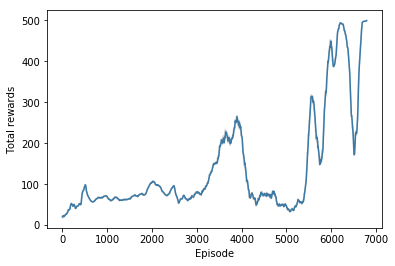

In [21]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

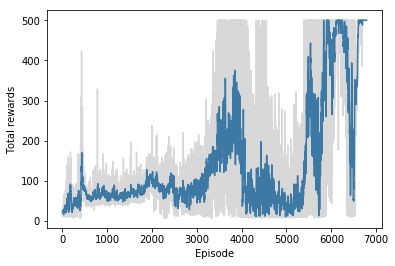

In [22]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

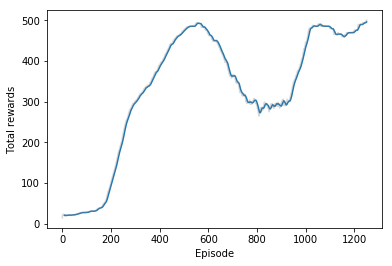

In [18]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

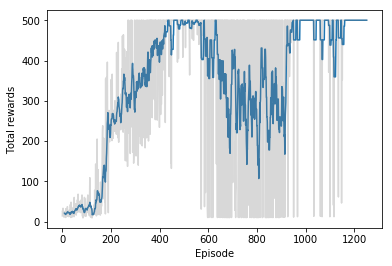

In [19]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

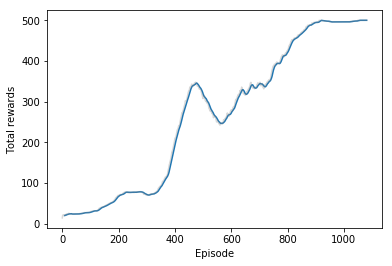

In [22]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

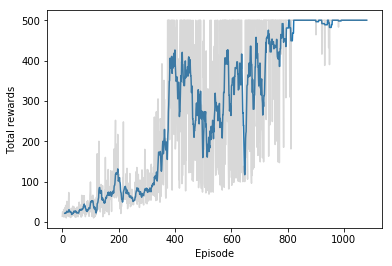

In [24]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

In [25]:
# eps, arr = np.array(dloss_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [26]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(10):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
